Source - https://www.kaggle.com/code/mgmarques/customer-segmentation-and-market-basket-analysis#Customer-Segmentation:


Data set is of a UK based customer sales company

In [1]:
# install necessary dependencies


In [83]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import math
from matplotlib import cm

import datetime
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox

In [3]:
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('whitegrid')
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [4]:
# other libraries
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
cd_or_df = pd.read_excel("../data/Online Retail.xlsx")

In [6]:
cd_or_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

**Data Description**

- **InvoiceNo**: a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: product name.
- **Quantity**: the quantities of each product (item) per transaction.
- **InvoiceDate**: the day and time when each transaction was generated.
- **UnitPrice**: product price per unit.
- **CustomerID**: a 5-digit integral number uniquely assigned to each customer.
- **Country**: the name of the country where each customer resides.

## Exploratory Data Analysis

In [7]:
cd_or_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
cd_or_df.duplicated().sum()

5268

In [9]:
cd_or_df.dtypes.value_counts()

object            4
float64           2
int64             1
datetime64[ns]    1
Name: count, dtype: int64

There are some duplicates involved in the data, which needs to be removed further down the line.

In [10]:
# getting internal details of the data using a function

def get_structure(df):
    n_rows = df.shape[0]
    d_types = df.dtypes
    total_cnt = df.count()
    null_cnt = df.isnull().sum()
    missing_perc = (null_cnt / n_rows) * 100
    unq_vals = df.apply(lambda x: x.unique().shape[0])
    total_unq = df.apply(lambda x: x.unique()).apply(lambda x: list(x))
    numeric_cols = df.select_dtypes(include=[np.number])
    kurtosis = numeric_cols.kurt()
    skewness = numeric_cols.skew()

    summary = pd.DataFrame({
        'Data Type': d_types,
        'Non-Null Count': total_cnt,
        'Null Count': null_cnt,
        'Missing Percentage (%)': missing_perc.round(2),
        'Number of Unique Values': unq_vals,
        'Sample Unique Values': total_unq
    })

    if not numeric_cols.empty:
        summary['Skewness'] = skewness
        summary['Kurtosis'] = kurtosis
    else:
        summary['Skewness'] = "N/A"
        summary['Kurtosis'] = "N/A"
    
    return summary

In [11]:
data_stru = get_structure(cd_or_df)
display(data_stru.sort_values(by='Missing Percentage (%)', ascending=False))

Data Type  Non-Null Count  Null Count  \
CustomerID          float64          406829      135080   
Description          object          540455        1454   
InvoiceNo            object          541909           0   
StockCode            object          541909           0   
Quantity              int64          541909           0   
InvoiceDate  datetime64[ns]          541909           0   
UnitPrice           float64          541909           0   
Country              object          541909           0   

             Missing Percentage (%)  Number of Unique Values  \
CustomerID                    24.93                     4373   
Description                    0.27                     4224   
InvoiceNo                      0.00                    25900   
StockCode                      0.00                     4070   
Quantity                       0.00                      722   
InvoiceDate                    0.00                    23260   
UnitPrice                      0.00                     1630   
Country                        0.00                       38   

                                          Sample Unique Values    Skewness  \
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.029835   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...   -0.264076   
InvoiceDate  [2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  186.506972   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  Kurtosis  
CustomerID       -1.179982  
Description            NaN  
InvoiceNo              NaN  
StockCode              NaN  
Quantity     119769.160031  
InvoiceDate            NaN  
UnitPrice     59005.719097  
Country                NaN

And `CustomerId` missing meaning, that purchase is not associated with any customer and it does not add any signficance to our analysis and we can remove those records if necessary.

In [12]:
cd_or_df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

From the above data we can notice that `UnitPrice` and `Quantity` are some how negative which should not be the case generally. I have to disect the data more and understand at what situations it is negative and why before fixing it.

In [13]:
# checking if the occurance of negative values are in the same records

cd_or_df[(cd_or_df['Quantity']<0) & (cd_or_df['UnitPrice']<0)]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [14]:
# checking if there are any records with 0
cd_or_df[(cd_or_df['Quantity']==0) & (cd_or_df['UnitPrice']==0)]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [15]:
# checking if there are any records with 0 either or
cd_or_df[(cd_or_df['Quantity']==0) | (cd_or_df['UnitPrice']==0)].shape

(2515, 8)

In [16]:
# checking 0 and negatives
cd_or_df[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0)].shape

(11805, 8)

In [17]:
# getting unique customerid for these type of data

cd_or_df.loc[(cd_or_df['Quantity']==0) | (cd_or_df['UnitPrice']==0), ['CustomerID']]['CustomerID'].unique()

array([   nan, 12647., 16560., 14911., 13081., 15107., 17560., 13239.,
       13113., 14410., 12457., 17667., 12415., 16818., 12507., 15581.,
       14646., 16133., 12748., 15804., 12446., 18059., 14110., 12437.,
       12431., 13014., 13985., 15602., 12603., 12444., 16406., 13256.])

In [18]:
# getting unique customerid for these type of data

cd_or_df.loc[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0), ['CustomerID']]['CustomerID'].unique()

array([14527., 15311., 17548., ..., 12985., 15951., 16446.])

In [19]:
# remove these kind of records

# step 1: removing the duplicates
cd_or_df.drop_duplicates(inplace=True)

In [20]:
# step_2: removing the missing values data

cd_or_df.dropna(subset=['CustomerID'], inplace=True)

In [21]:
# negative Quantity and Unitprice

cd_or_df = cd_or_df[(cd_or_df['Quantity'] >= 0) & (cd_or_df['UnitPrice'] > 0)]

In [22]:
cd_or_df[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0)].shape

(0, 8)

In [23]:
data_stru = get_structure(cd_or_df)
display(data_stru.sort_values(by='Missing Percentage (%)', ascending=False))

Data Type  Non-Null Count  Null Count  \
InvoiceNo            object          392692           0   
StockCode            object          392692           0   
Description          object          392692           0   
Quantity              int64          392692           0   
InvoiceDate  datetime64[ns]          392692           0   
UnitPrice           float64          392692           0   
CustomerID          float64          392692           0   
Country              object          392692           0   

             Missing Percentage (%)  Number of Unique Values  \
InvoiceNo                       0.0                    18532   
StockCode                       0.0                     3665   
Description                     0.0                     3877   
Quantity                        0.0                      301   
InvoiceDate                     0.0                    17282   
UnitPrice                       0.0                      440   
CustomerID                      0.0                     4338   
Country                         0.0                       37   

                                          Sample Unique Values    Skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  407.345663   
InvoiceDate  [2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  202.740861   
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.030148   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  Kurtosis  
InvoiceNo              NaN  
StockCode              NaN  
Description            NaN  
Quantity     175940.085113  
InvoiceDate            NaN  
UnitPrice     57398.335042  
CustomerID       -1.180692  
Country                NaN

Weirdly the total number unique values in `Description` are comparitively more than the `StockCode`.

In [24]:
cat_desc_df = cd_or_df.groupby(["StockCode", "Description"]).size().reset_index(name="Count")

In [25]:
cat_desc_df.tail()

StockCode                 Description  Count
3892        C2                    CARRIAGE    133
3893       DOT              DOTCOM POSTAGE     16
3894         M                      Manual    279
3895      PADS  PADS TO MATCH ALL CUSHIONS      3
3896      POST                     POSTAGE   1099

In [26]:
cat_desc_df['StockCode'].value_counts()[cat_desc_df['StockCode'].value_counts()>1].reset_index().head()

StockCode  count
0     23196      4
1     23236      4
2     23203      3
3    17107D      3
4     23535      3

The issue here is that `StockCode` is having alphabetic characters which is invalid.

And also there are some `StockCode`'s which have different `Description`s which should not be the case. 

In [27]:
# Analyze alphabetical StockCodes

cat_desc_df[cat_desc_df["StockCode"].str.contains(r"[A-Za-z]", regex=True, na=False)]

StockCode                  Description  Count
2996    10123C        HEARTS WRAPPING TAPE       3
2997    10124A  SPOTS ON RED BOOKCOVER TAPE      5
2998    10124G     ARMY CAMO BOOKCOVER TAPE      4
2999    15044A          PINK PAPER PARASOL      78
3000    15044B          BLUE PAPER PARASOL      48
...        ...                          ...    ...
3892        C2                     CARRIAGE    133
3893       DOT               DOTCOM POSTAGE     16
3894         M                       Manual    279
3895      PADS   PADS TO MATCH ALL CUSHIONS      3
3896      POST                      POSTAGE   1099

[901 rows x 3 columns]

In [28]:
target_stock_code = (
    cat_desc_df['StockCode']
    .value_counts()
    .reset_index()
    .loc[5, 'StockCode']
)
filtered_description = cd_or_df[cd_or_df['StockCode'] == target_stock_code]['Description'].unique()
print(filtered_description)

['LUNCH BAG DOILEY PATTERN ' 'LUNCH BAG VINTAGE DOILY '
 'LUNCH BAG VINTAGE DOILEY ']


This highlights how multiple descriptions for the same item can arise, showcasing the simple yet impactful ways data quality can be compromised in any dataset. Even a minor spelling mistake can significantly degrade data quality and lead to inaccurate analysis.

In [29]:
unique_desc = (
    cd_or_df[["StockCode", "Description"]]
    .groupby("StockCode")["Description"]
    .apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    .reset_index()
    .rename(columns={"Description": "Description_unique"})
)

cd_or_df = cd_or_df.merge(unique_desc, on="StockCode", how="left")

In [30]:
cd_or_df.drop(["Description"], inplace=True, axis=1)

In [31]:
cd_or_df.rename(columns = {
    "Description_unique" : "Description"
}, inplace=True)

In [32]:
cd_or_df["InvoiceDate"] = pd.to_datetime(cd_or_df["InvoiceDate"])
cd_or_df["amount"] = cd_or_df["Quantity"]*cd_or_df["UnitPrice"]
cd_or_df["CustomerID"] = cd_or_df["CustomerID"].astype("int64")

In [33]:
data_stru_cd = get_structure(cd_or_df)
display(data_stru_cd.sort_values(by='Missing Percentage (%)', ascending=False))

Data Type  Non-Null Count  Null Count  \
InvoiceNo            object          392692           0   
StockCode            object          392692           0   
Quantity              int64          392692           0   
InvoiceDate  datetime64[ns]          392692           0   
UnitPrice           float64          392692           0   
CustomerID            int64          392692           0   
Country              object          392692           0   
Description          object          392692           0   
amount              float64          392692           0   

             Missing Percentage (%)  Number of Unique Values  \
InvoiceNo                       0.0                    18532   
StockCode                       0.0                     3665   
Quantity                        0.0                      301   
InvoiceDate                     0.0                    17282   
UnitPrice                       0.0                      440   
CustomerID                      0.0                     4338   
Country                         0.0                       37   
Description                     0.0                     3647   
amount                          0.0                     2939   

                                          Sample Unique Values    Skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  407.345663   
InvoiceDate  [2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  202.740861   
CustomerID   [17850, 13047, 12583, 13748, 15100, 15291, 146...    0.030148   
Country      [United Kingdom, France, Australia, Netherland...         NaN   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
amount       [15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...  448.521779   

                  Kurtosis  
InvoiceNo              NaN  
StockCode              NaN  
Quantity     175940.085113  
InvoiceDate            NaN  
UnitPrice     57398.335042  
CustomerID       -1.180692  
Country                NaN  
Description            NaN  
amount       229148.857198

Some of the stockcodes also have same description...

In [34]:
duplicates = (
    cd_or_df.groupby("Description")["StockCode"]
    .nunique()
    .reset_index()
    .rename(columns={"StockCode": "UniqueStockCodes"})
)

duplicates = duplicates[duplicates["UniqueStockCodes"] > 1]

In [35]:
result = cd_or_df.merge(duplicates, on="Description")

In [36]:
result

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  CustomerID  \
0      536446     10133         5 2010-12-01 12:15:00       0.85       15983   
1      536621     10135        10 2010-12-02 10:35:00       1.25       13108   
2      537126     10135         1 2010-12-05 12:13:00       1.25       18118   
3      537126     10133         1 2010-12-05 12:13:00       0.85       18118   
4      537129     10135        10 2010-12-05 12:15:00       1.25       13506   
..        ...       ...       ...                 ...        ...         ...   
817    560359    81953B         1 2011-07-18 11:47:00       0.19       14159   
818    560359    81952B         6 2011-07-18 11:47:00       0.19       14159   
819    560828    81952B         1 2011-07-21 11:55:00       0.19       14298   
820    561045    81952B        10 2011-07-24 12:29:00       0.19       17522   
821    561322    81952B        18 2011-07-26 13:03:00       0.19       15203   

            Country                   Description  amount  UniqueStockCodes  
0    United Kingdom  COLOURING PENCILS BROWN TUBE    4.25                 2  
1    United Kingdom  COLOURING PENCILS BROWN TUBE   12.50                 2  
2    United Kingdom  COLOURING PENCILS BROWN TUBE    1.25                 2  
3    United Kingdom  COLOURING PENCILS BROWN TUBE    0.85                 2  
4    United Kingdom  COLOURING PENCILS BROWN TUBE   12.50                 2  
..              ...                           ...     ...               ...  
817  United Kingdom  ROUND BLUE CLOCK WITH SUCKER    0.19                 2  
818  United Kingdom  ROUND BLUE CLOCK WITH SUCKER    1.14                 2  
819  United Kingdom  ROUND BLUE CLOCK WITH SUCKER    0.19                 2  
820  United Kingdom  ROUND BLUE CLOCK WITH SUCKER    1.90                 2  
821  United Kingdom  ROUND BLUE CLOCK WITH SUCKER    3.42                 2  

[822 rows x 10 columns]

#### Visualizations

In [37]:
cust_data = cd_or_df.copy()

In [38]:
# understanding from which country most of the customers are from

country_counts = cust_data.groupby(["Country"])["CustomerID"] \
                            .count() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

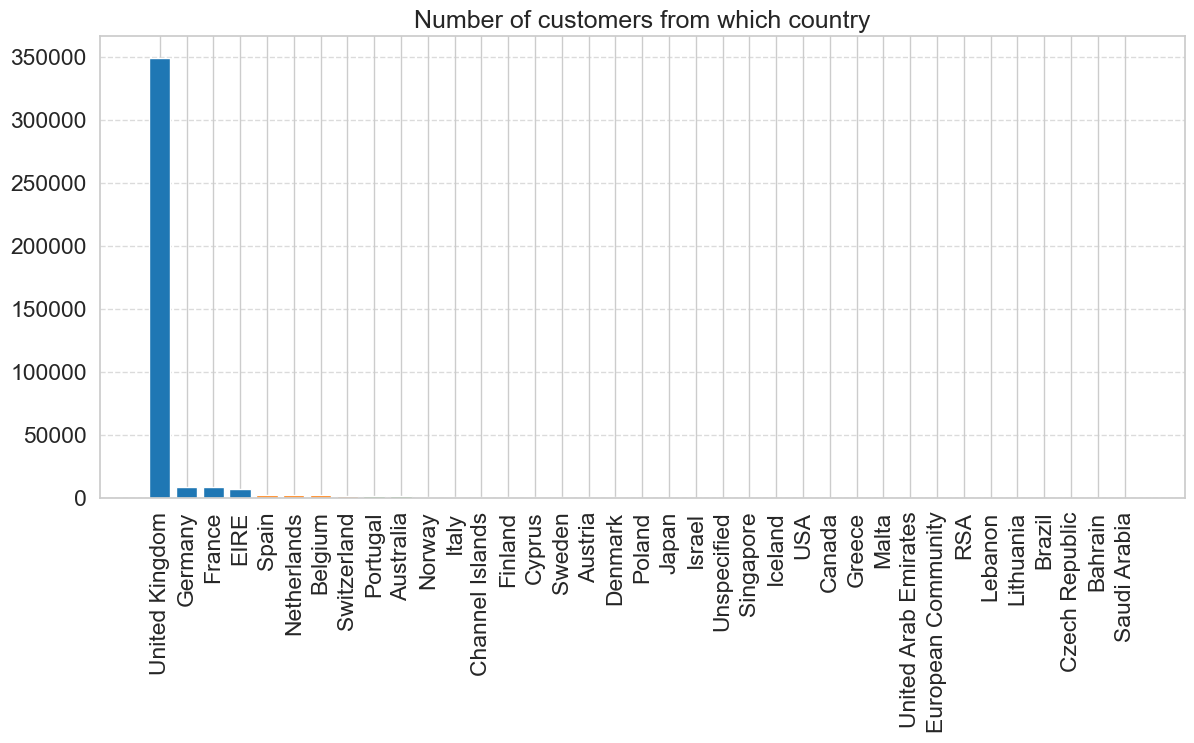

In [39]:
colors = [plt.cm.tab10(i / len(country_counts)) for i in range(len(country_counts))]

plt.figure(figsize=(14,6))
plt.bar(country_counts.index, country_counts["count"], color = colors)
plt.title('Number of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

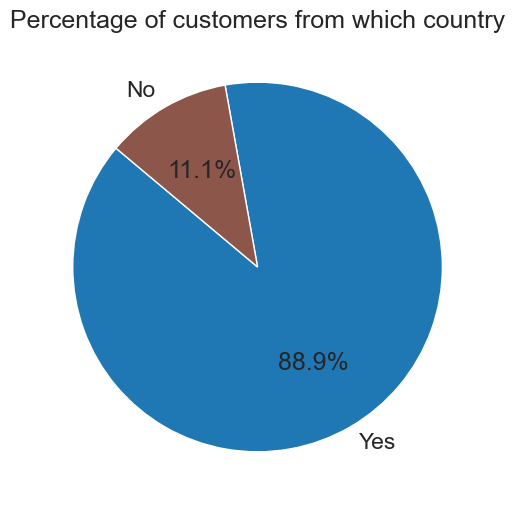

In [40]:
# percentage of Customers from UK and Rest of the World

cust_data["internal_sales"] = cust_data.apply(lambda x: "Yes" if x["Country"] == "United Kingdom" else "No", axis=1)

uk_counts = cust_data.groupby(["internal_sales"])["CustomerID"] \
                            .count() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

colors = [plt.cm.tab10(i / len(uk_counts)) for i in range(len(uk_counts))]

plt.figure(figsize=(8,6))
plt.pie(uk_counts["count"], 
    labels=uk_counts.index, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140)
plt.title('Percentage of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [41]:
# by amount

country_counts = cust_data.groupby(["Country"])["amount"] \
                            .sum() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

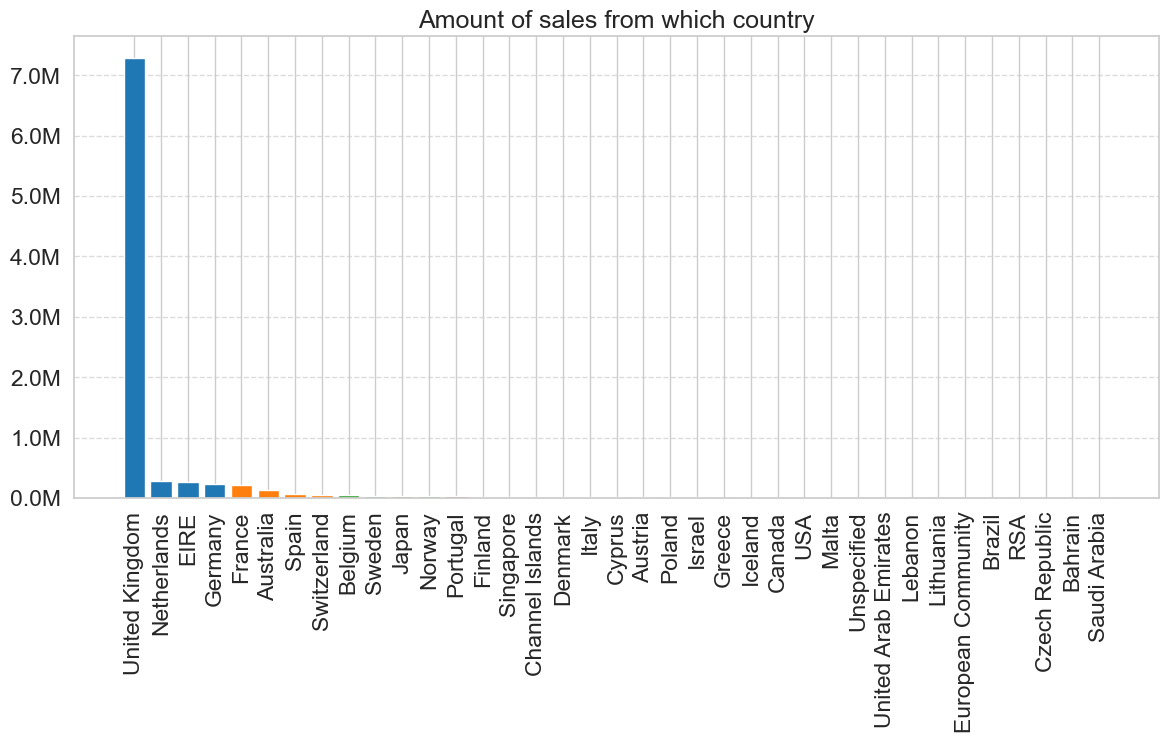

In [42]:
colors = [plt.cm.tab10(i / len(country_counts)) for i in range(len(country_counts))]

plt.figure(figsize=(14,6))
plt.bar(country_counts.index, country_counts["count"], color = colors)
plt.title('Amount of sales from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
formatter = FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

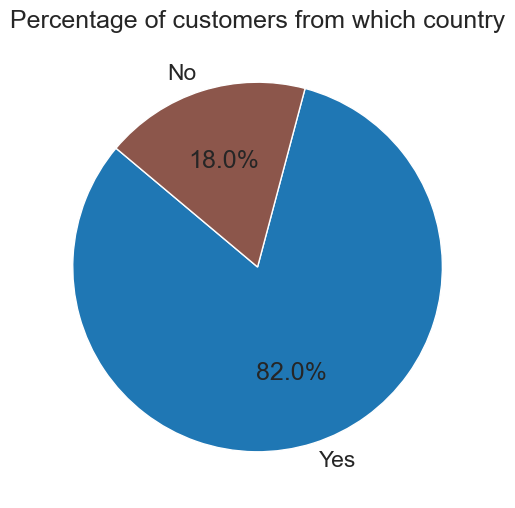

In [43]:
# percentage of sales from UK and Rest of the World
uk_counts = cust_data.groupby(["internal_sales"])["amount"] \
                            .sum() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

colors = [plt.cm.tab10(i / len(uk_counts)) for i in range(len(uk_counts))]

plt.figure(figsize=(8,6))
plt.pie(uk_counts["count"], 
    labels=uk_counts.index, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140)
plt.title('Percentage of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [44]:
# Top Customers

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].sum()
     .sort_values(ascending = False)[:51]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False).sum()*100,                                                    # Step 6: Convert the ratio to a percentage
    2)

In [45]:
# top customers

top_cust = cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False)[:51].to_frame(name = "count")

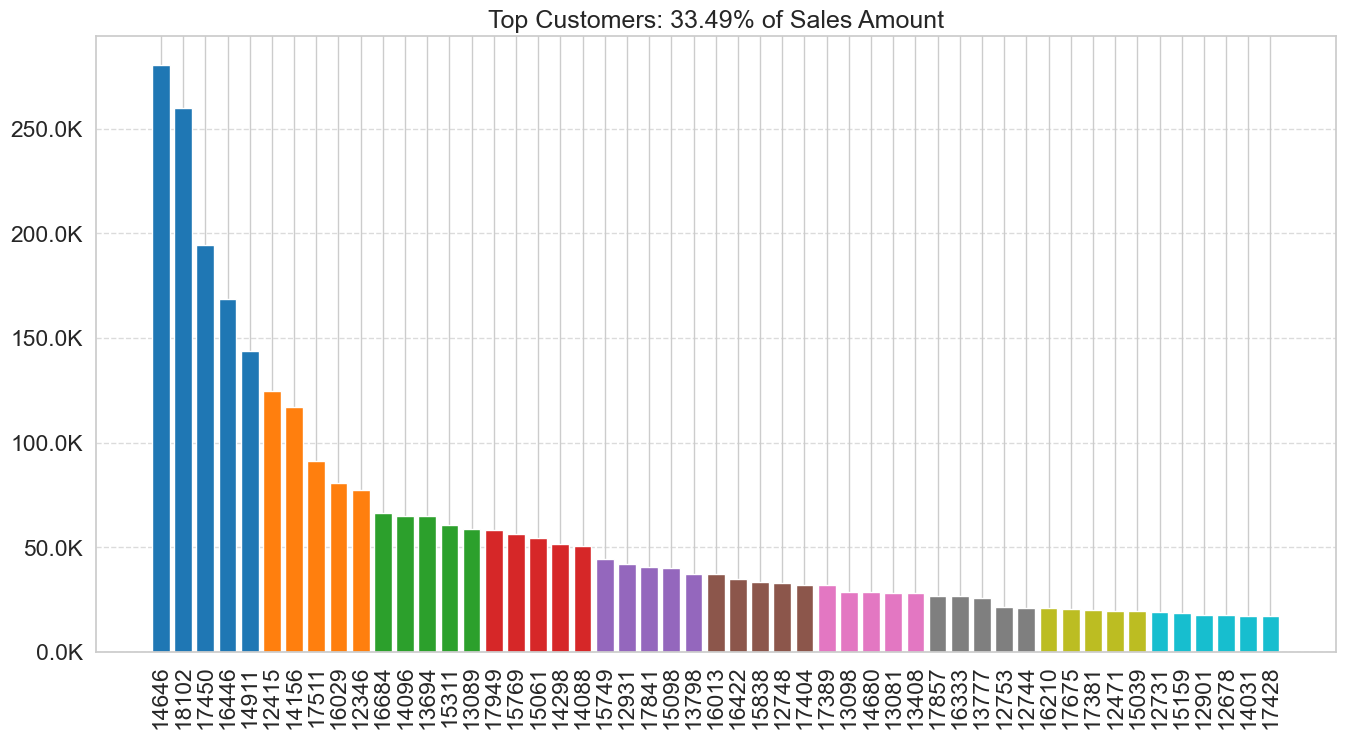

In [46]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of Sales Amount')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [47]:
# Top 15 Customers

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].sum()
     .sort_values(ascending = False)[:15]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False).sum()*100,                                                    # Step 6: Convert the ratio to a percentage
    2)

# top customers

top_cust = cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False)[:15].to_frame(name = "count")

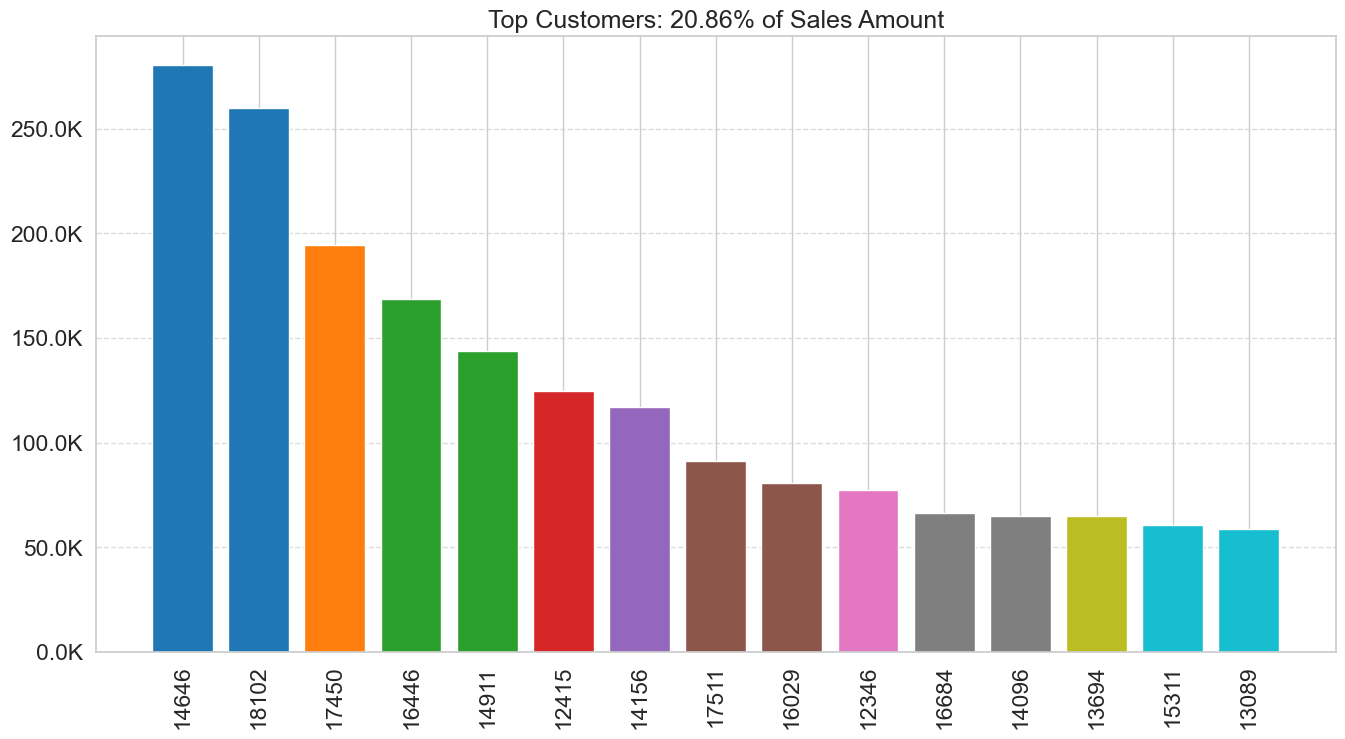

In [48]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of Sales Amount')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [49]:
# Top 15 Customers - by events

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].count()
     .sort_values(ascending = False)[:15]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].count().sort_values(ascending = False).sum()*100,
    2)

# top customers - by events

top_cust = cust_data.groupby(["CustomerID"])["amount"].count().sort_values(ascending = False)[:15].to_frame(name = "count")

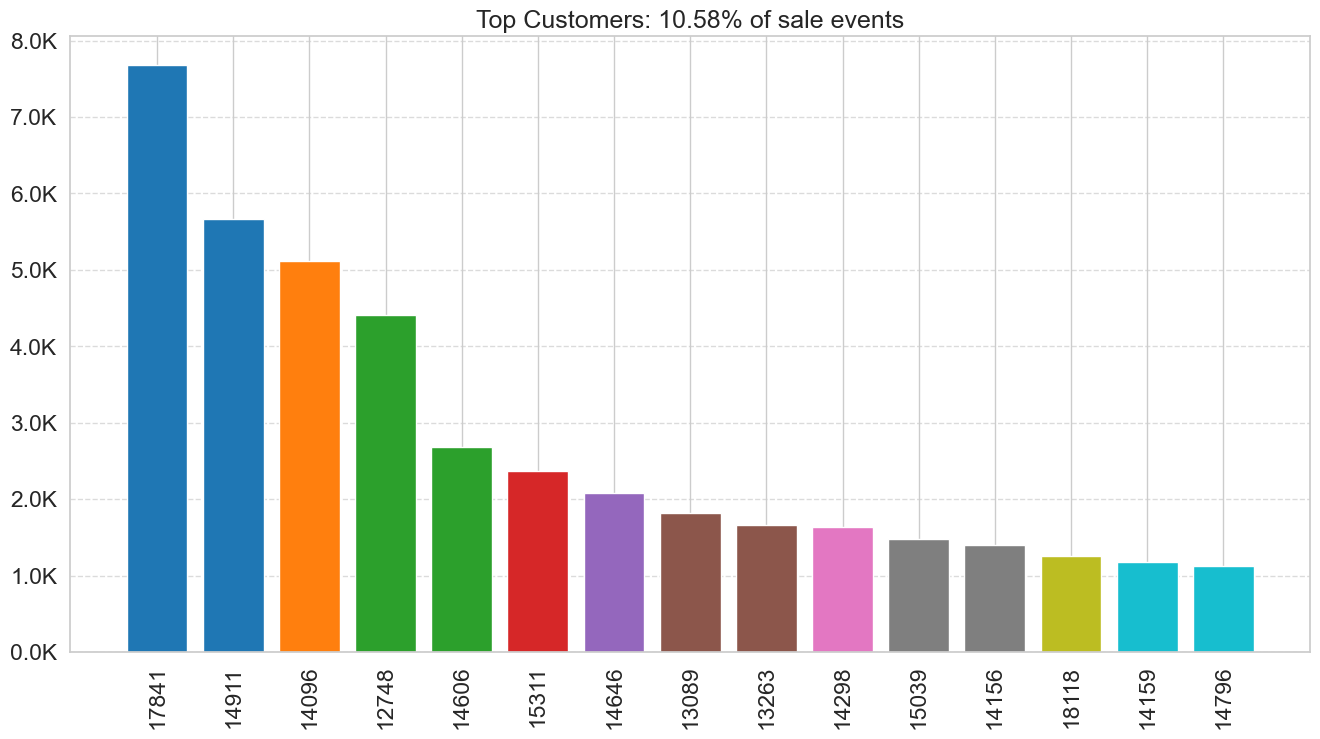

In [50]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of sale events')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [51]:
AmoutSum = cust_data.groupby(["Description"]).amount.sum().sort_values(ascending=False)
inv = cust_data.groupby("Description")["InvoiceNo"].nunique().sort_values(ascending=False)

sns.set(style="whitegrid")

In [52]:
Top15 = list(AmoutSum[:15].index)
PercentSales = np.round((AmoutSum[Top15].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15].sum() / inv.sum()) * 100, 2)

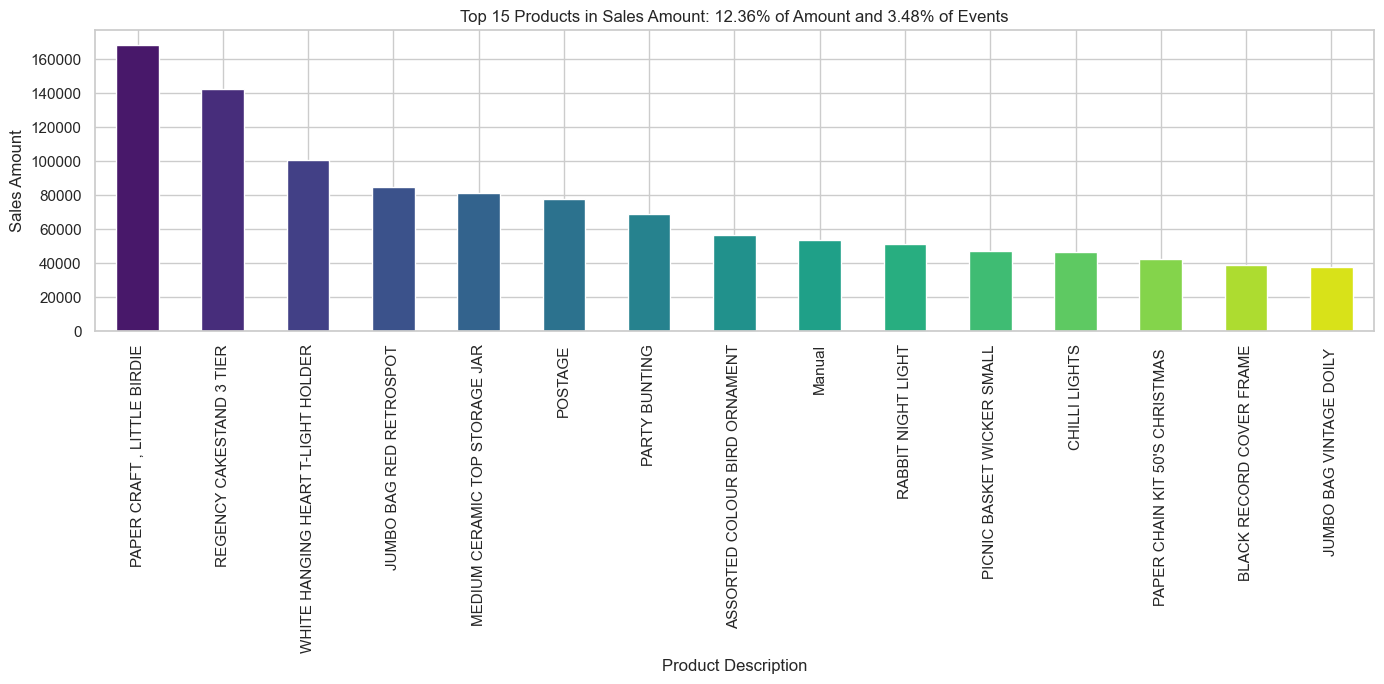

In [53]:
plt.figure(figsize=(14, 7))
colors1 = sns.color_palette("viridis", len(Top15))
AmoutSum[Top15].plot(kind='bar', color=colors1,
                     title=f'Top 15 Products in Sales Amount: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')

plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

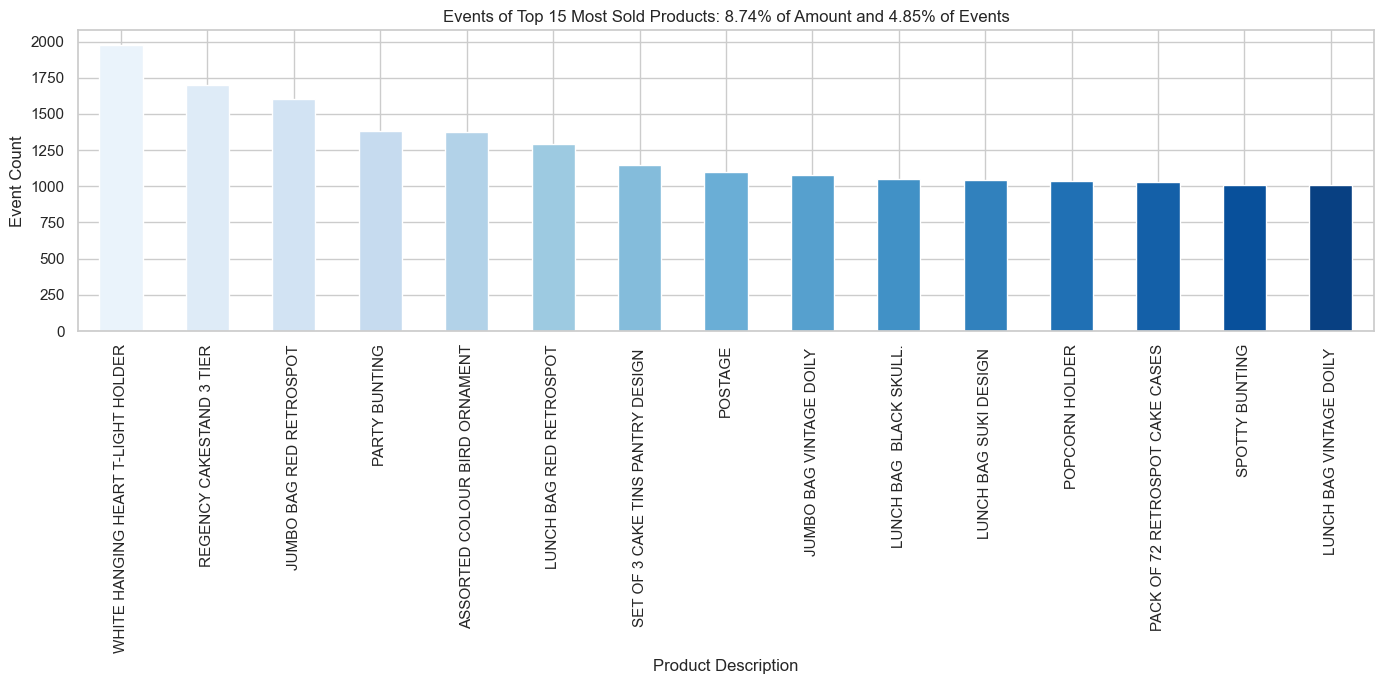

In [54]:
fig2 = plt.figure(figsize=(14, 7))
Top15Ev = list(inv[:15].index)
PercentSales = np.round((AmoutSum[Top15Ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15Ev].sum() / inv.sum()) * 100, 2)
colors2 = sns.color_palette("Blues", len(Top15Ev))

inv[Top15Ev].plot(kind='bar', color=colors2,
                   title=f'Events of Top 15 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Event Count')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

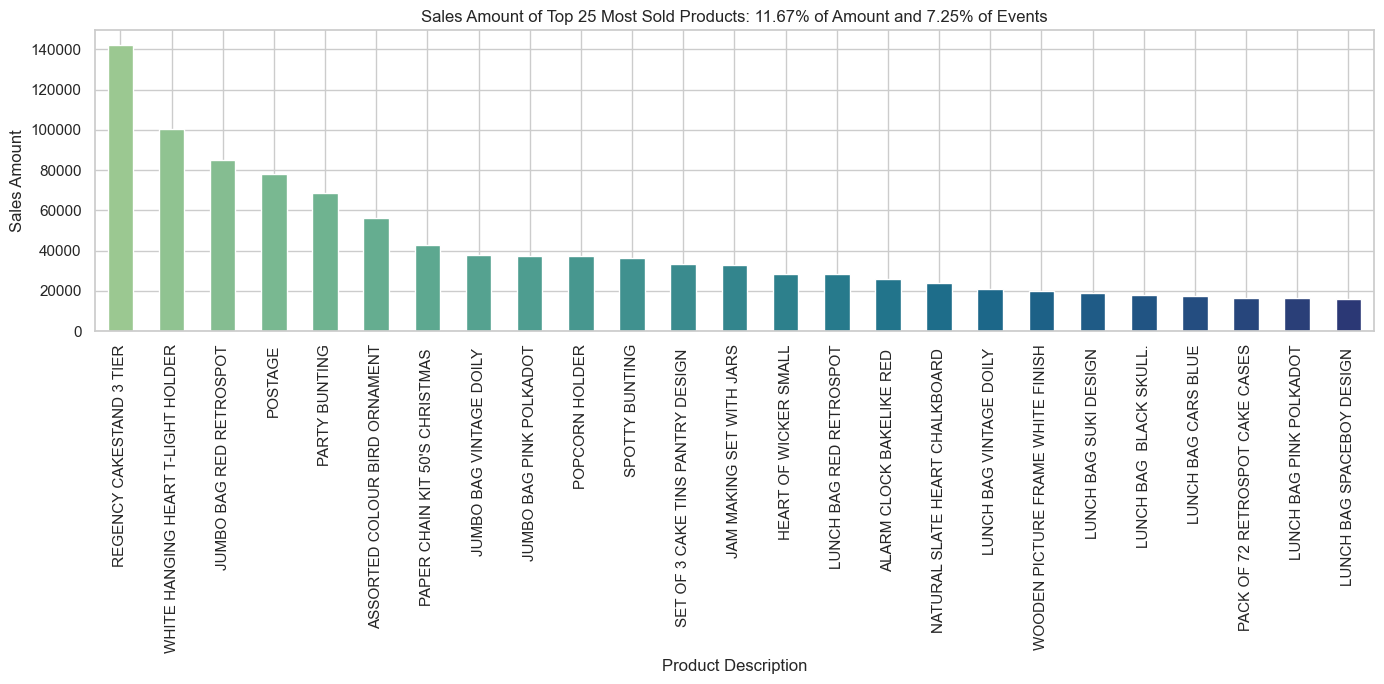

In [55]:
fig3 = plt.figure(figsize=(14, 7))
Top25ev = list(inv[:25].index)
PercentSales = np.round((AmoutSum[Top25ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top25ev].sum() / inv.sum()) * 100, 2)
colors3 = sns.color_palette("crest", len(Top25ev))
AmoutSum[Top25ev].sort_values(ascending=False).plot(kind='bar', color=colors3,
                                                     title=f'Sales Amount of Top 25 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

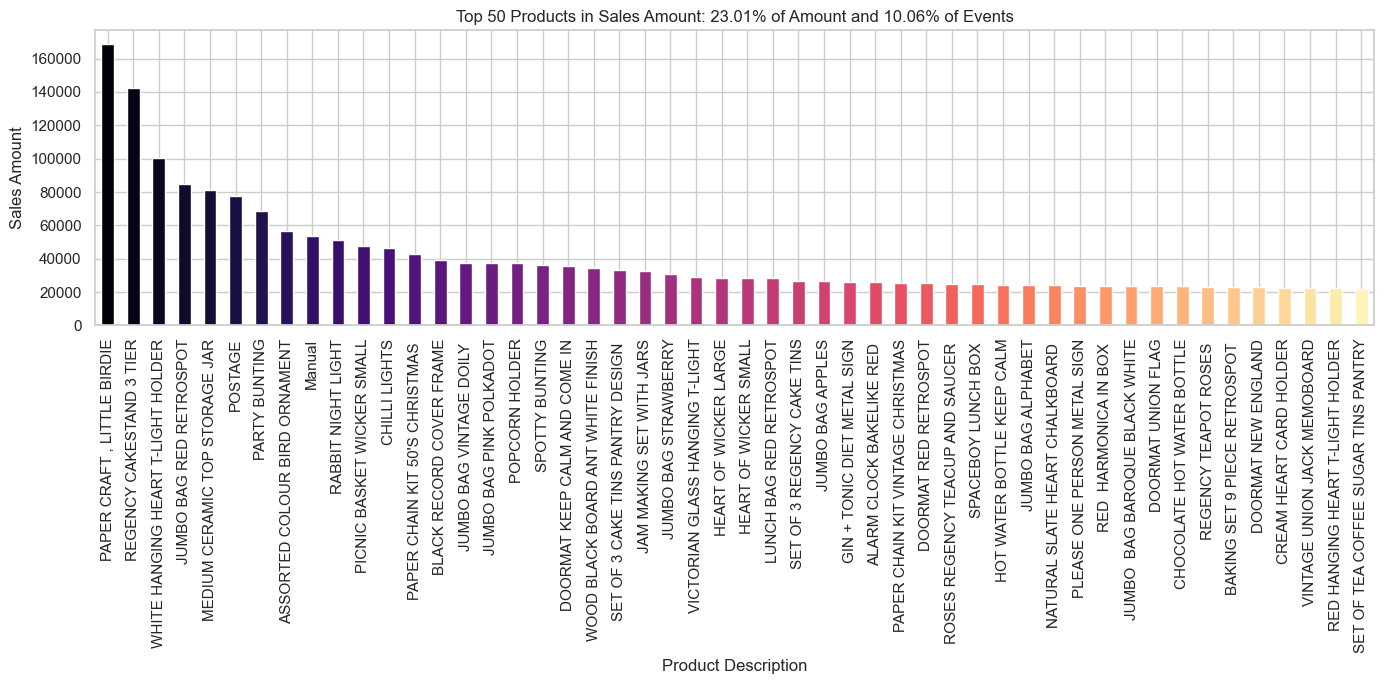

In [56]:
fig4 = plt.figure(figsize=(14, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales = np.round((AmoutSum[Top50].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum() / inv.sum()) * 100, 2)
colors4 = sns.color_palette("magma", len(Top50))
AmoutSum[Top50].plot(kind='bar', color=colors4,
                      title=f'Top 50 Products in Sales Amount: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

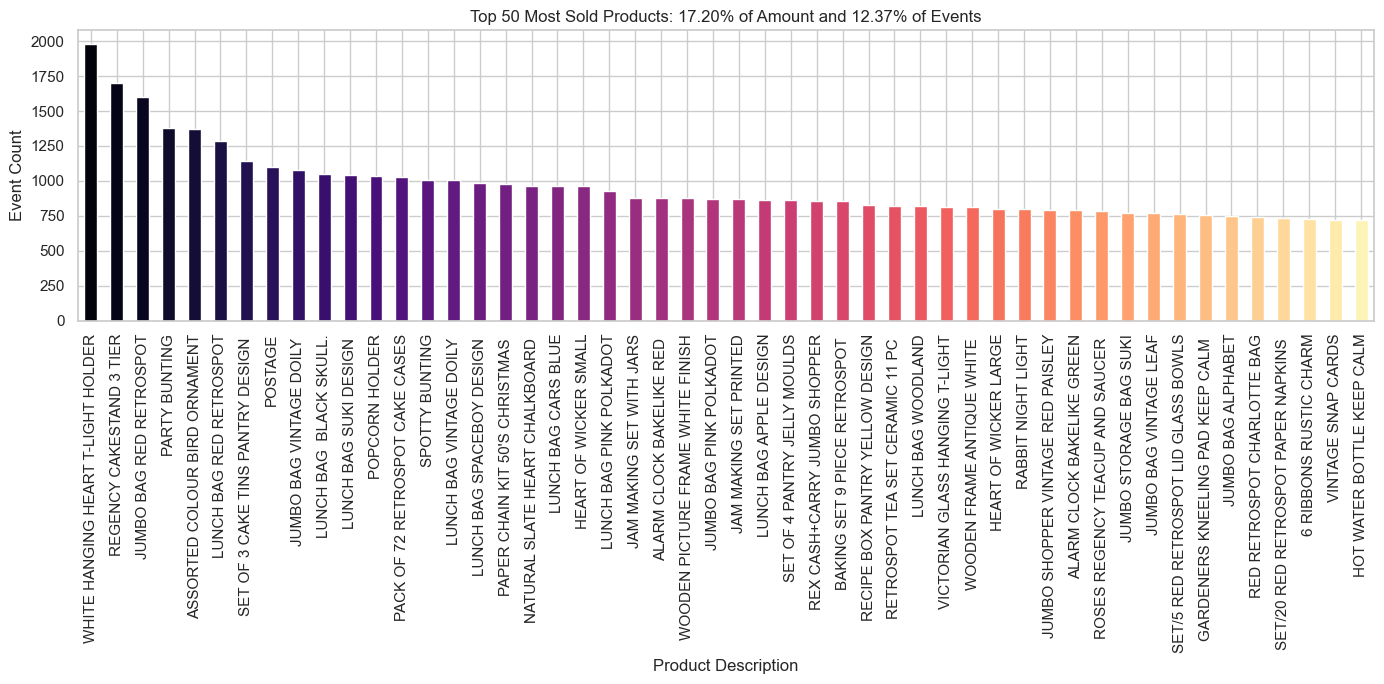

In [57]:
fig5 = plt.figure(figsize=(14, 7))
Top50Ev = list(inv[:50].index)
PercentSales = np.round((AmoutSum[Top50Ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum() / inv.sum()) * 100, 2)
colors5 = sns.color_palette("magma", len(Top50Ev))
inv[Top50Ev].plot(kind='bar', color=colors5,
                  title=f'Top 50 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Event Count')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

#### Customer Segmentation:

Customer segmentation involves dividing an organization’s customer base into distinct groups or segments based on various customer attributes. This process aims to identify differences in customer behaviors and patterns.

The key objectives and benefits of customer segmentation include:

1. **Higher Revenue**: This is often the primary goal of any customer segmentation initiative.
2. **Customer Understanding**: A commonly accepted business principle is “know your customer.” Segmenting the customer base allows organizations to gain deeper insights into their customers.
3. **Targeted Marketing**: Customer segmentation enables more focused and efficient marketing efforts. By understanding the distinct segments within their customer base, organizations can create tailored marketing campaigns, increasing the likelihood of their success.
4. **Optimal Product Placement**: A well-executed segmentation strategy can help firms develop new products, bundle offerings, or align product placement more effectively with customer needs.
5. **Identifying Untapped Segments**: It can also reveal latent customer segments, allowing organizations to target untapped markets through specialized marketing campaigns or business development strategies.

---

### Methods of Customer Segmentation:

**Clustering**:  
A common approach to customer segmentation is using unsupervised machine learning techniques such as clustering. This involves gathering extensive data on customer attributes, identifying clusters within the data, and analyzing the traits of these clusters to understand customer segments better.

**Exploratory Data Analysis (EDA)**:  
EDA is another method for discovering customer segments, typically performed by domain experts familiar with the products and customers. It offers a flexible approach to analyzing data, highlighting key decision points and insights.

---

### RFM Model for Customer Value:

Given a dataset limited to sales records without additional customer details, the RFM (Recency, Frequency, Monetary Value) model can be used to segment customers based on their value. This model calculates three essential attributes from customer transactions:

- **Recency**: The number of days since the customer's last purchase.
- **Frequency**: The number of transactions made by the customer.
- **Monetary Value**: The total monetary value of a customer's transactions.

To create the recency feature, a reference date is required, typically set as the day after the last transaction. The recency variable is then calculated as the number of days between the reference date and the customer’s most recent purchase date. 

By analyzing these RFM attributes, businesses can effectively segment customers and tailor strategies to maximize engagement and revenue.

**Recency**

To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [58]:
clust_data = cd_or_df.copy()

In [59]:
# Adding reference data which is the next day of last invoice date

ref_date = clust_data["InvoiceDate"].max() + datetime.timedelta(days = 1)

In [60]:
clust_data['days_since_last_pur'] = (ref_date - clust_data['InvoiceDate']).dt.days
cust_hist_df =  clust_data[['CustomerID', 'days_since_last_pur']].groupby('CustomerID').min().reset_index()
cust_hist_df.rename(columns={'days_since_last_pur':'recency'}, inplace=True)
cust_hist_df.describe().transpose()

count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency       142.00    374.0

Next thing would be to understand if the recency data is normally distrubuted using the `Recency Distribution` and `Q-Q` plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

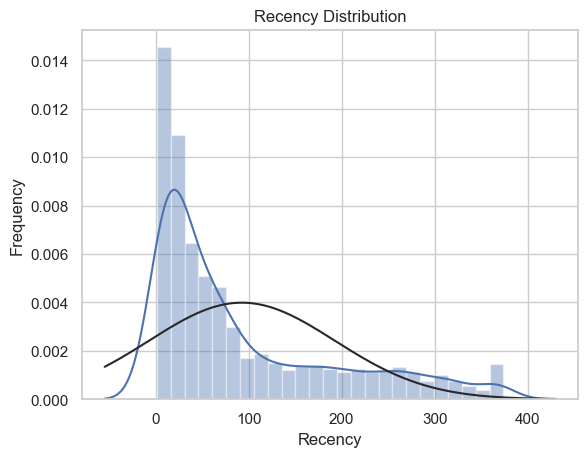

In [61]:
# Kernel Density Plot

sns.distplot(cust_hist_df['recency'], fit=norm)
plt.title('Recency Distribution', loc='center')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

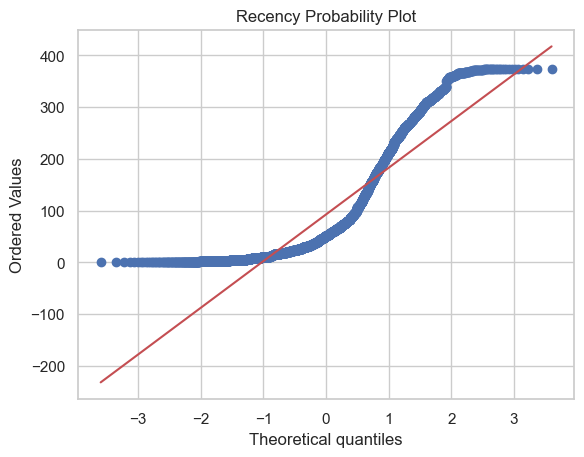

In [62]:
# Q-Q plot

probplot(cust_hist_df['recency'], dist="norm", plot=plt)
plt.title('Recency Probability Plot', loc='center')
plt.show()

In [63]:
print(f"Skewness: {cust_hist_df['recency'].skew():.2f} and Kurtosis: {cust_hist_df['recency'].kurt():.2f}")

Skewness: 1.25 and Kurtosis: 0.43


The sales recency distribution exhibits a clear skewness, with a pronounced peak on the left side and a long tail extending to the right. This shape indicates that the data is positively skewed and deviates significantly from a normal distribution. Such a distribution implies that most values are concentrated near the lower range, while a smaller number of higher values extend the tail to the right.

The probability plot further supports this observation. The data points deviate from the diagonal red line, which represents a perfect alignment with a normal distribution. The visible gap between the data points and the line confirms that the sales recency distribution is not symmetric and is skewed to the right.

A skewness value of 1.25 reinforces the conclusion that the data lacks symmetry. Positive skewness indicates that the right tail is disproportionately long relative to the left tail, aligning with the characteristics observed in the distribution plot. In contrast, a normal distribution would have a skewness value of zero, with symmetric data showing skewness values near zero.

Kurtosis, which measures the heaviness of the tails in a distribution, further highlights the nature of the sales recency data. With a kurtosis value of 0.43, the data demonstrates a heavy-tailed distribution, indicating the presence of outliers. Positive kurtosis values, like this one, suggest that the tails are heavier than those of a normal distribution, while negative kurtosis would indicate lighter tails.

In summary, the sales recency data is positively skewed, with a lack of symmetry and heavier tails than a normal distribution. The skewness and kurtosis values, along with the visual observations from the distribution and probability plots, confirm the presence of outliers and a long right tail.

**Frequency**

In [64]:
cust_freq = clust_data.groupby(["CustomerID"])["InvoiceNo"].nunique().reset_index(name = "count")

In [65]:
cust_freq.rename(columns={'count':'frequency'},inplace=True)
cust_hist_df = cust_hist_df.merge(cust_freq)

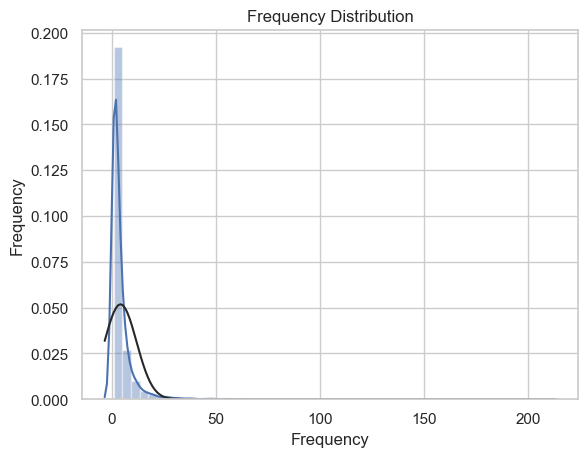

In [66]:
# Kernel Density Plot

sns.distplot(cust_hist_df['frequency'], fit=norm)
plt.title('Frequency Distribution', loc='center')
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.show()

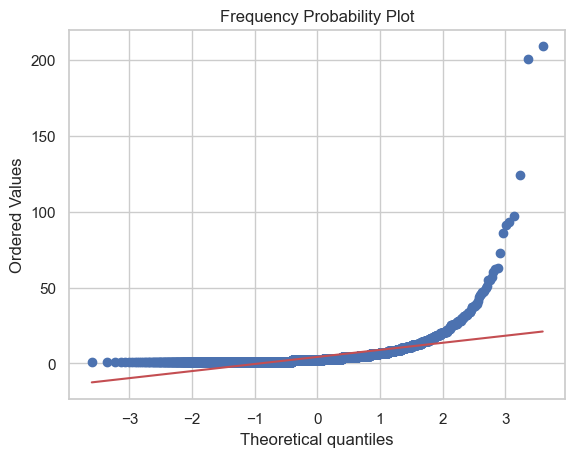

In [67]:
# Q-Q plot

probplot(cust_hist_df['frequency'], dist="norm", plot=plt)
plt.title('Frequency Probability Plot', loc='center')
plt.show()

In [68]:
print(f"Skewness: {cust_hist_df['frequency'].skew():.2f} and Kurtosis: {cust_hist_df['frequency'].kurt():.2f}")

Skewness: 12.07 and Kurtosis: 249.06


The first graph reveals that the sales frequency distribution is positively skewed, with a pronounced peak on the left and a long tail extending to the right. This indicates a deviation from a normal distribution and a clear positive bias.

The probability plot further supports this observation, as the sales frequency data does not align with the diagonal line representing a normal distribution. This misalignment confirms that the distribution is skewed to the right.

With a skewness value of 12.1, the data exhibits a significant lack of symmetry. Additionally, a kurtosis value of 249 indicates a heavy-tailed distribution with the presence of outliers.

**Monetary Value**

In [69]:
cust_mon_val = clust_data[['CustomerID', 'amount']].groupby('CustomerID').sum().reset_index()
cust_hist_df = cust_hist_df.merge(cust_mon_val)

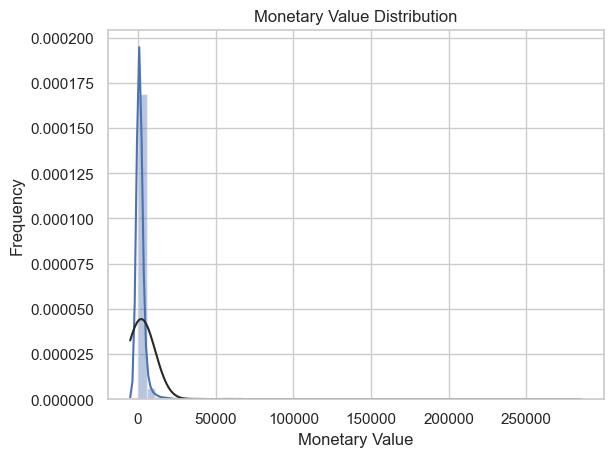

In [70]:
# Kernel Density Plot

sns.distplot(cust_hist_df['amount'], fit=norm)
plt.title('Monetary Value Distribution', loc='center')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.show()

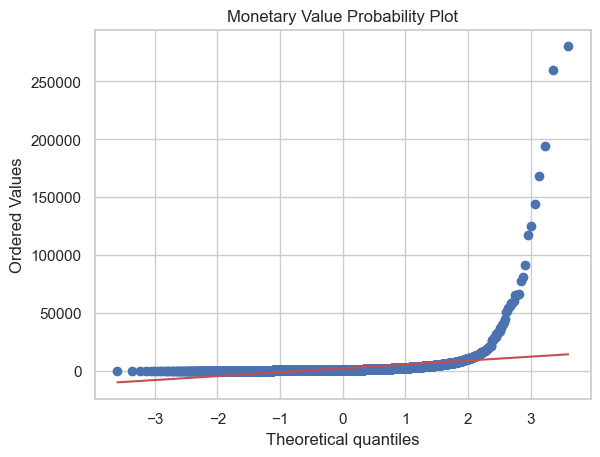

In [71]:
# Q-Q plot

probplot(cust_hist_df['amount'], dist="norm", plot=plt)
plt.title('Monetary Value Probability Plot', loc='center')
plt.show()

In [72]:
print(f"Skewness: {cust_hist_df['amount'].skew():.2f} and Kurtosis: {cust_hist_df['amount'].kurt():.2f}")

Skewness: 19.34 and Kurtosis: 478.68


The first graph shows that the sales amount distribution is positively skewed, with a sharp peak on the left and a long tail extending to the right. This indicates a deviation from a normal distribution and a clear positive bias.

The probability plot further highlights this pattern, as the sales amount data does not align with the diagonal line representing a normal distribution, particularly on the right side.

A skewness value of 19.3 confirms a significant lack of symmetry, while a kurtosis value of 478 indicates an extremely heavy-tailed distribution with numerous outliers. It is evident that there are more than 10 very extreme outliers in the data.

In [73]:
cust_hist_df.describe()

CustomerID      recency    frequency         amount
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    15299.500000    51.000000     2.000000     668.570000
75%    16778.750000   142.000000     5.000000    1660.597500
max    18287.000000   374.000000   209.000000  280206.020000

#### Data Preprocessing

To prepare the customer value dataset for K-means clustering, we must preprocess the data to ensure optimal algorithm performance:

1. **Mean Centering (Standardization):**  
   Replace variable values with standardized ones to achieve a mean of 0 and variance of 1. This ensures all variables are on the same scale, preventing value range differences from affecting clustering performance.

2. **Log Transformation:**  
   Variables, especially monetary amounts, often have wide value ranges. Applying a log transformation alongside standardization ensures the data is scaled and normalized.

3. **Reversible Transformation:**  
   Since clustering results will use transformed data, reversing the process allows inferences in the original scale. Python's preprocessing tools can handle this transformation and its reversal effectively.

In [74]:
cust_hist_df['recency_log'] = np.log(cust_hist_df['recency'])
cust_hist_df['frequency_log'] = np.log(cust_hist_df['frequency'])
cust_hist_df['amount_log'] = np.log(cust_hist_df['amount'])

feature_vector = ['amount_log', 'recency_log', 'frequency_log']

X_subset = cust_hist_df[feature_vector]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_vector)

X_scaled_df.describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0  5.241440e-17  1.000115 -4.172381 -0.682096 -0.063857   
recency_log    4338.0 -1.048288e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -9.991495e-17  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.657274  4.722173  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

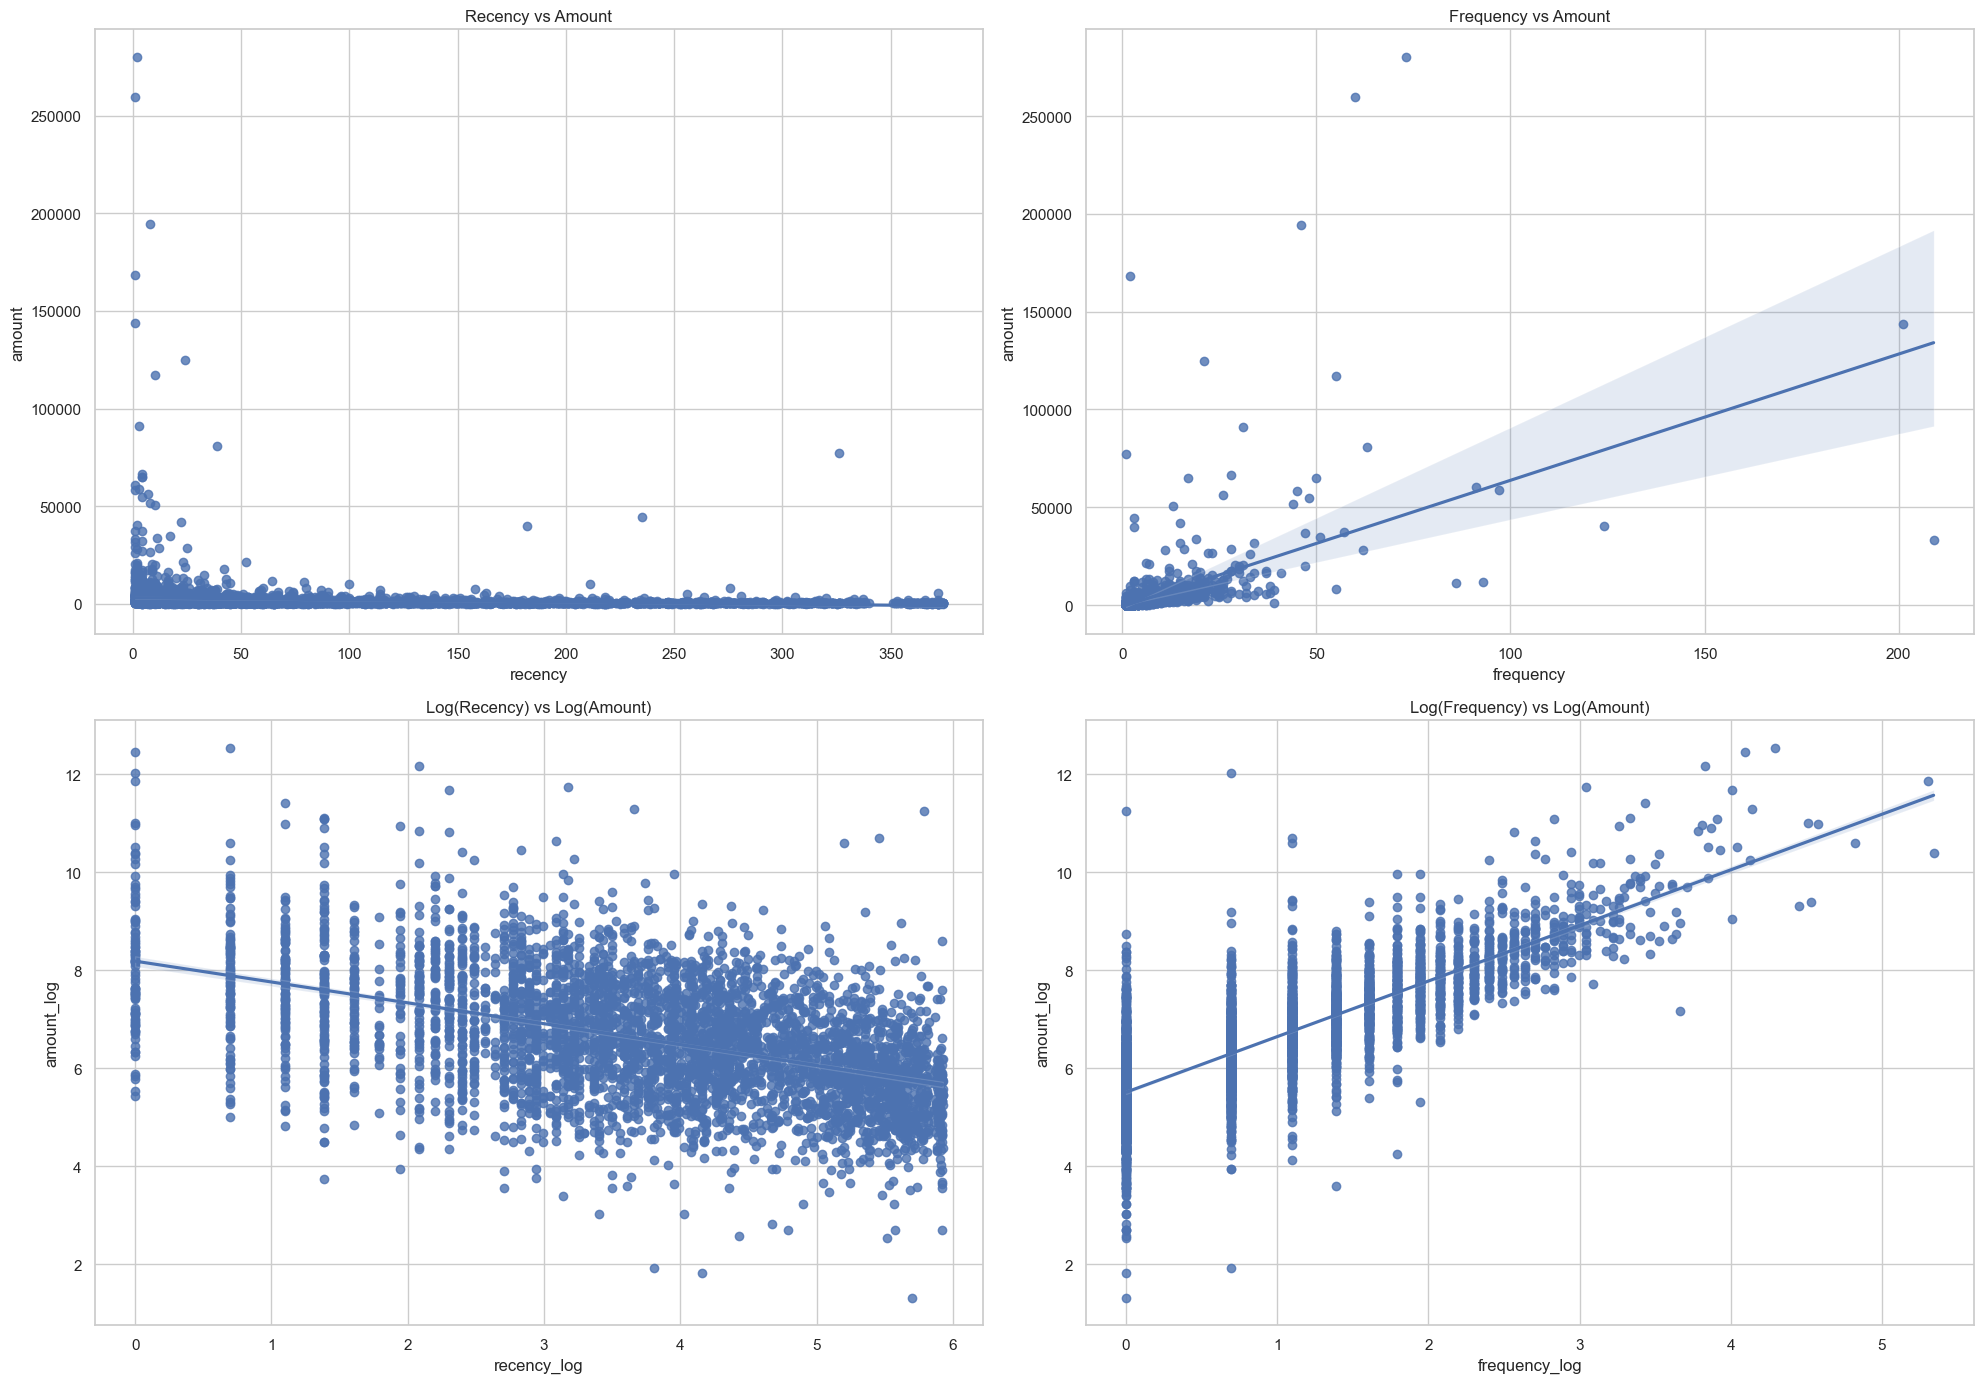

In [75]:
fig = plt.figure(figsize=(20, 14))

# Plot 1: Recency vs. Amount
ax1 = fig.add_subplot(221)
sns.regplot(x='recency', y='amount', data=cust_hist_df, ax=ax1)
ax1.set_title('Recency vs Amount')

# Plot 2: Frequency vs. Amount
ax2 = fig.add_subplot(222)
sns.regplot(x='frequency', y='amount', data=cust_hist_df, ax=ax2)
ax2.set_title('Frequency vs Amount')

# Plot 3: Log-transformed Recency vs Log-transformed Amount
ax3 = fig.add_subplot(223)
sns.regplot(x='recency_log', y='amount_log', data=cust_hist_df, ax=ax3)
ax3.set_title('Log(Recency) vs Log(Amount)')

# Plot 4: Log-transformed Frequency vs Log-transformed Amount
ax4 = fig.add_subplot(224)
sns.regplot(x='frequency_log', y='amount_log', data=cust_hist_df, ax=ax4)
ax4.set_title('Log(Frequency) vs Log(Amount)')

# Display the pairwise plots
plt.tight_layout()
plt.show()

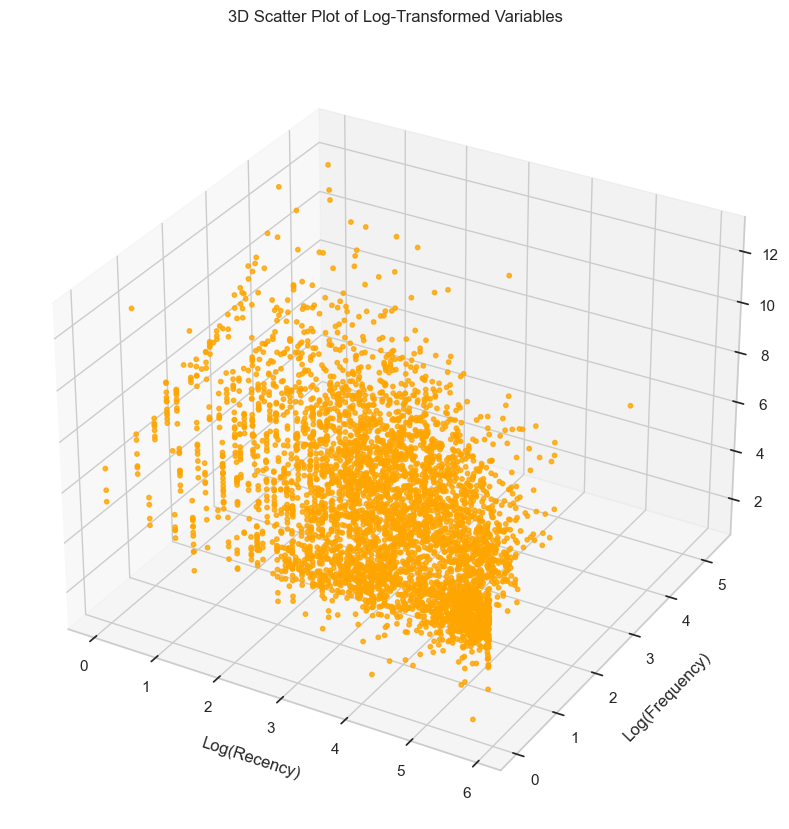

In [76]:
# 3D Scatter Plot for Log-transformed Variables
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with log-transformed values
xs = cust_hist_df['recency_log']
ys = cust_hist_df['frequency_log']
zs = cust_hist_df['amount_log']
ax.scatter(xs, ys, zs, s=10, alpha=0.8, c='orange')

# Set axis labels
ax.set_xlabel('Log(Recency)', labelpad=10)
ax.set_ylabel('Log(Frequency)', labelpad=10)
ax.set_zlabel('Log(Monetary)', labelpad=10)

# Add a title
ax.set_title('3D Scatter Plot of Log-Transformed Variables', pad=20)

# Display the 3D plot
plt.show()

The plots above reveal clear patterns: customers who purchase more frequently and more recently tend to spend more. This is evident from the increasing trend in Monetary (amount spent) corresponding to an increase in Frequency and a decrease in Recency.

### Clustering for Segments: K-Means Clustering

#### Overview of K-Means Clustering
K-means is a **centroid-based partitioning algorithm** belonging to the hard clustering family, where each data point is assigned to exactly one cluster. The algorithm aims to minimize the **within-cluster sum of squared errors (SSE)**, also known as **cluster inertia**, by optimizing the following objective function:


#### Steps in the K-Means Algorithm:
1. **Initialization:**  
   Randomly initialize the cluster centroids for the specified number of clusters \(k\).  
2. **Assignment:**  
   Assign each data point to the cluster with the nearest centroid using the **Euclidean distance metric**.  
3. **Centroid Update:**  
   Recalculate the centroids by averaging the dimensions of all points assigned to each cluster.  
4. **Iteration:**  
   Repeat the assignment and centroid update steps until cluster assignments stabilize, at which point the algorithm terminates.

---

#### Enhancements: K-Means++
The **K-means++** algorithm improves the initialization process by placing the initial centroids far apart, leading to better and more consistent results compared to random initialization.  
In scikit-learn, K-means++ is the default initialization method and can be used by setting the `init` parameter to `"k-means++"`.

---

#### Determining Optimal Clusters: The Elbow Method
The **elbow method** helps identify the optimal number of clusters (\(k\)) by examining the distortion (SSE) as a function of \(k\). The process involves:  
1. Plotting distortion against the number of clusters.  
2. Identifying the "elbow point," where the rate of distortion reduction sharply decreases.  

This point represents the optimal number of clusters, as it balances between explaining the variance and avoiding overfitting.

- **Key Idea:** The elbow corresponds to the point where adding more clusters provides diminishing returns in terms of variance explained.
- **Percentage of Variance Explained:**  
   This metric is calculated as the ratio of between-group variance to total variance (similar to an F-test).  
   Alternatively, the curvature of the within-cluster variance can be plotted to identify the elbow.  

Note: The elbow is not always clearly identifiable, which may require additional techniques or domain expertise.

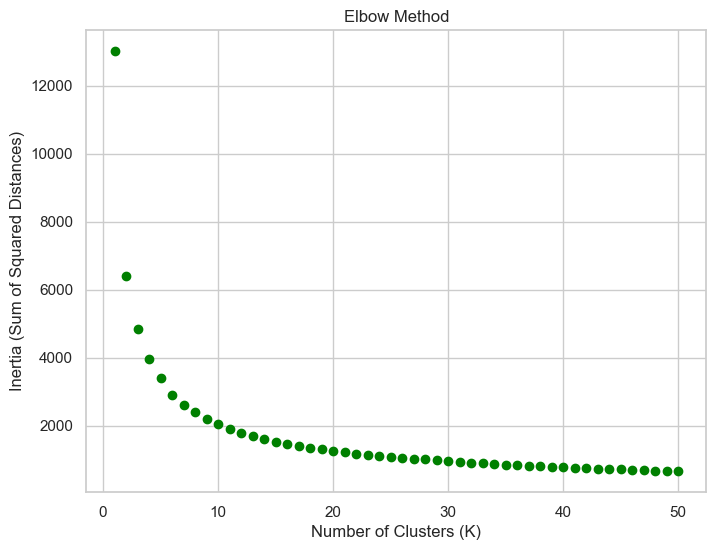

In [79]:
cl = 50
corte = 0.1

anterior = float('inf')
cost = [] 
K_best = cl

for k in range(1, cl+1):
    # Create a kmeans model on our data, using k clusters. random_state ensures consistent results.
    model = KMeans(
        n_clusters=k, 
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia) / anterior) < corte): 
        K_best = k - 1
    cost.append(interia)
    anterior = interia

# Plot inertia vs number of clusters
plt.figure(figsize=(8, 6))
plt.scatter(range(1, cl+1), cost, c='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method')
plt.show()

The best K suggests: 7


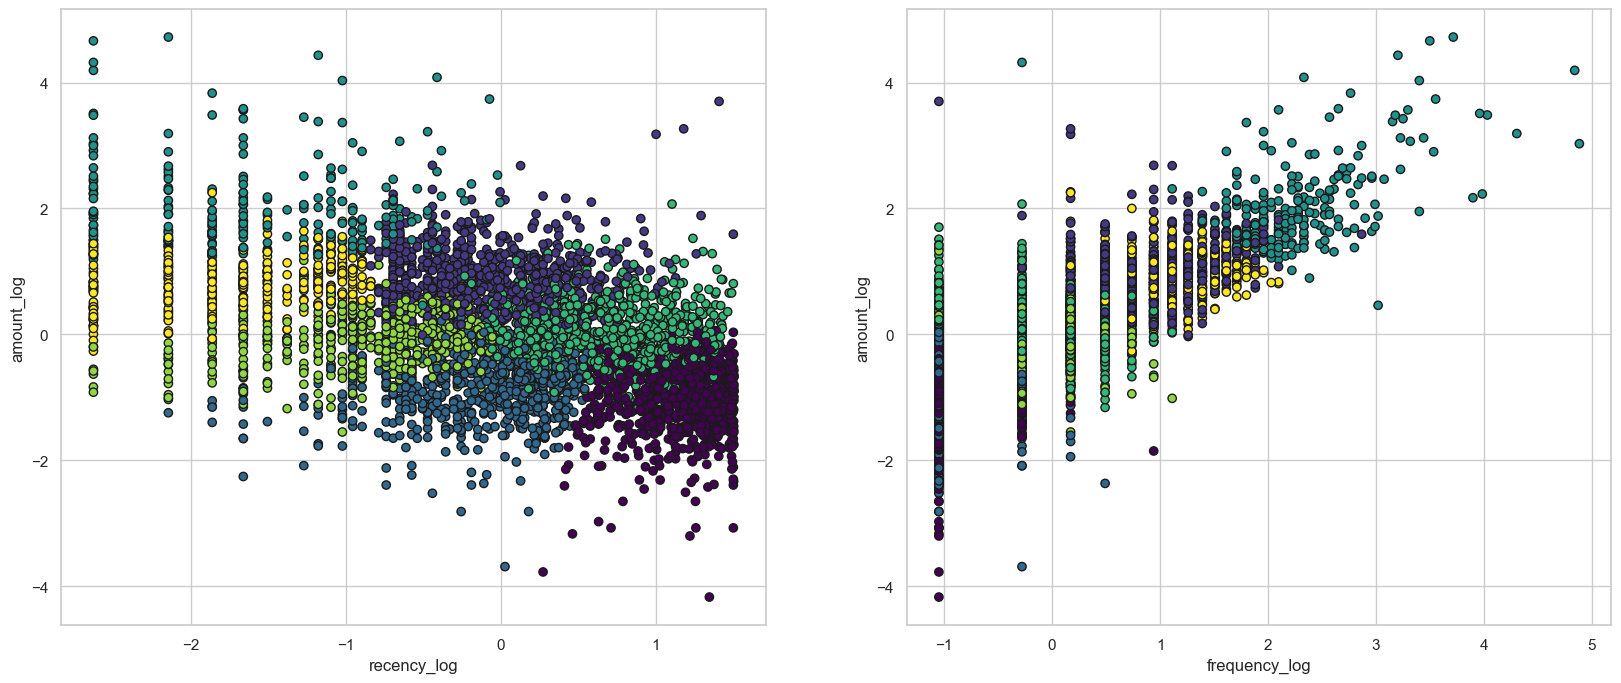

In [81]:
# Create a kmeans model with the best K.
print('The best K suggests:', K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=101)

# Fit the model to the scaled data
model = model.fit(X_scaled)

# Visualize clustering results with distinct colors using a colormap
fig = plt.figure(figsize=(20, 8))

# Plot for feature_vector[1] vs feature_vector[0]
ax1 = fig.add_subplot(121)
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=model.labels_, cmap='viridis', edgecolor='k')
ax1.set_xlabel(feature_vector[1])
ax1.set_ylabel(feature_vector[0])

# Plot for feature_vector[2] vs feature_vector[0]
ax2 = fig.add_subplot(122)
plt.scatter(X_scaled[:, 2], X_scaled[:, 0], c=model.labels_, cmap='viridis', edgecolor='k')
ax2.set_xlabel(feature_vector[2])
ax2.set_ylabel(feature_vector[0])

plt.show()

Note that by the Elbow method from a K equal to 3 we already observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 7. With this in mind, we will begin to evaluate the options more deeply with 3, and 7, starting with the silhouette analysis.


Silhouette analysis is a method used to evaluate how well-separated clusters are in a dataset. It helps assess the quality of clustering by measuring how cohesive the samples within each cluster are and how distinct they are from other clusters.

### Silhouette Coefficient Breakdown

- **Cohesion (a(i))**: This measures how similar points are within the same cluster. Lower values indicate that points are more tightly grouped together.
  
- **Separation (b(i))**: This measures how distinct a cluster is from its nearest neighboring cluster. Higher values indicate better separation between clusters.

- **Silhouette Score (s(i))**: This is calculated by subtracting cohesion from separation and dividing by the greater of the two.

### Interpretation of Silhouette Scores

- **Positive Scores**: Indicate strong separation between clusters.
- **Scores Near +1**: Suggest very distinct clusters.
- **Scores Around 0**: Indicate that points are close to the boundary between two clusters, which may point to misassignments or overlapping clusters.
- **Negative Scores**: Suggest that points are more closely related to another cluster, meaning they might be misclassified.

### Using Silhouette Analysis for Clustering

Silhouette analysis helps evaluate the quality of clusters. Ideally, all clusters should show similar silhouette scores, indicating balanced, well-separated groups. If scores fluctuate widely or contain negative values, it suggests that some clusters might need re-evaluation or adjustment in the number of clusters.

Additionally, scatter plots with cluster centers help visually assess the clusters and their separation from one another, providing a deeper understanding of the clustering performance.

### Balancing with Business Relevance

While silhouette analysis provides mathematical insights, it's essential to also consider business context. Practical applications often guide decisions, as results may need to be adjusted based on specific goals, industry relevance, or user requirements.

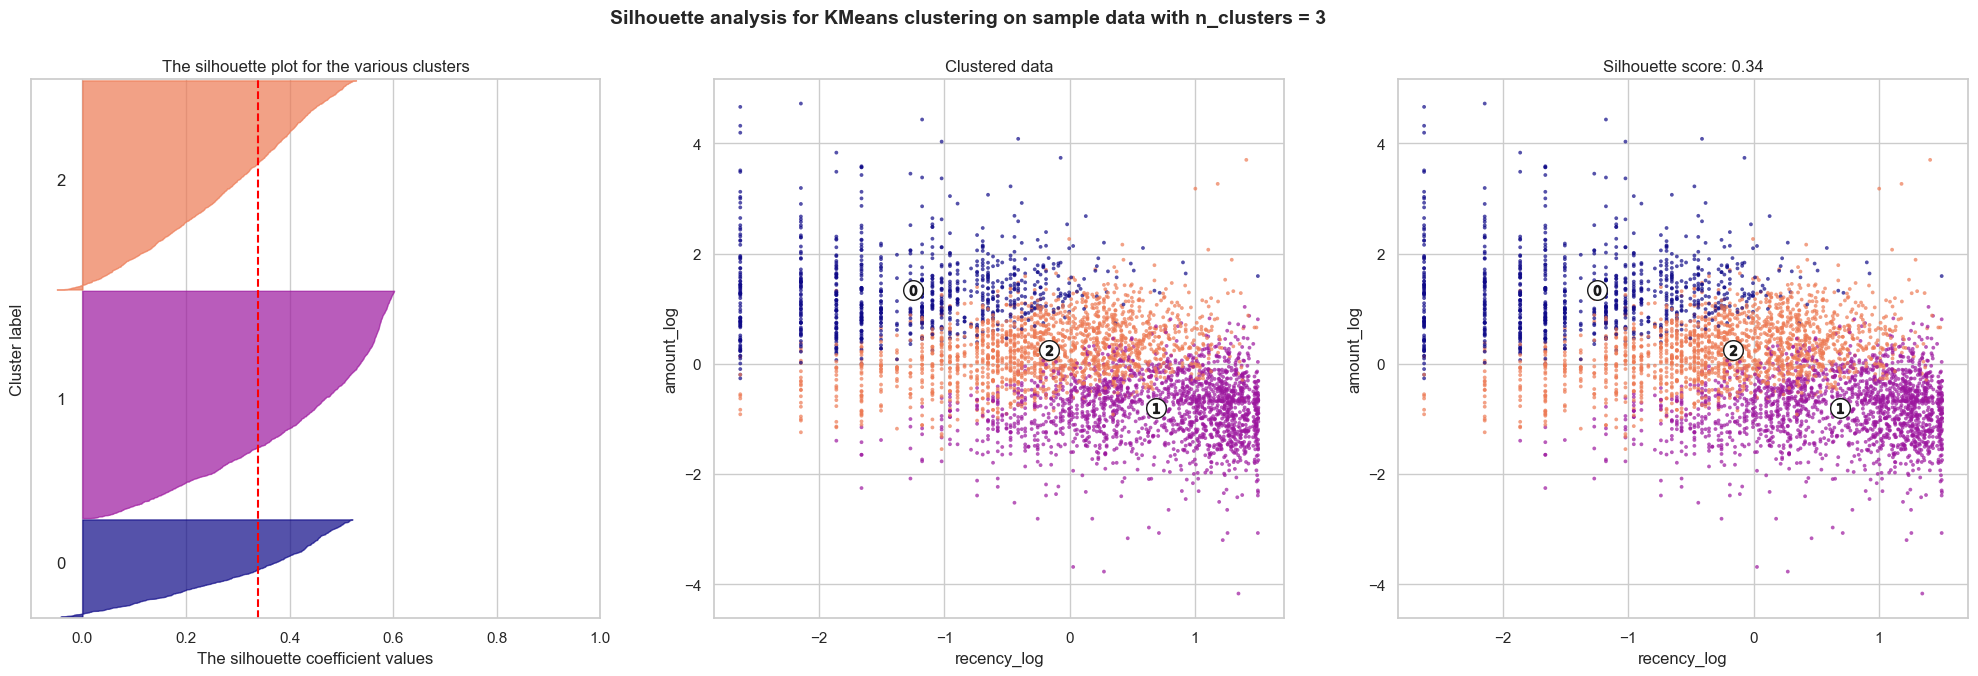

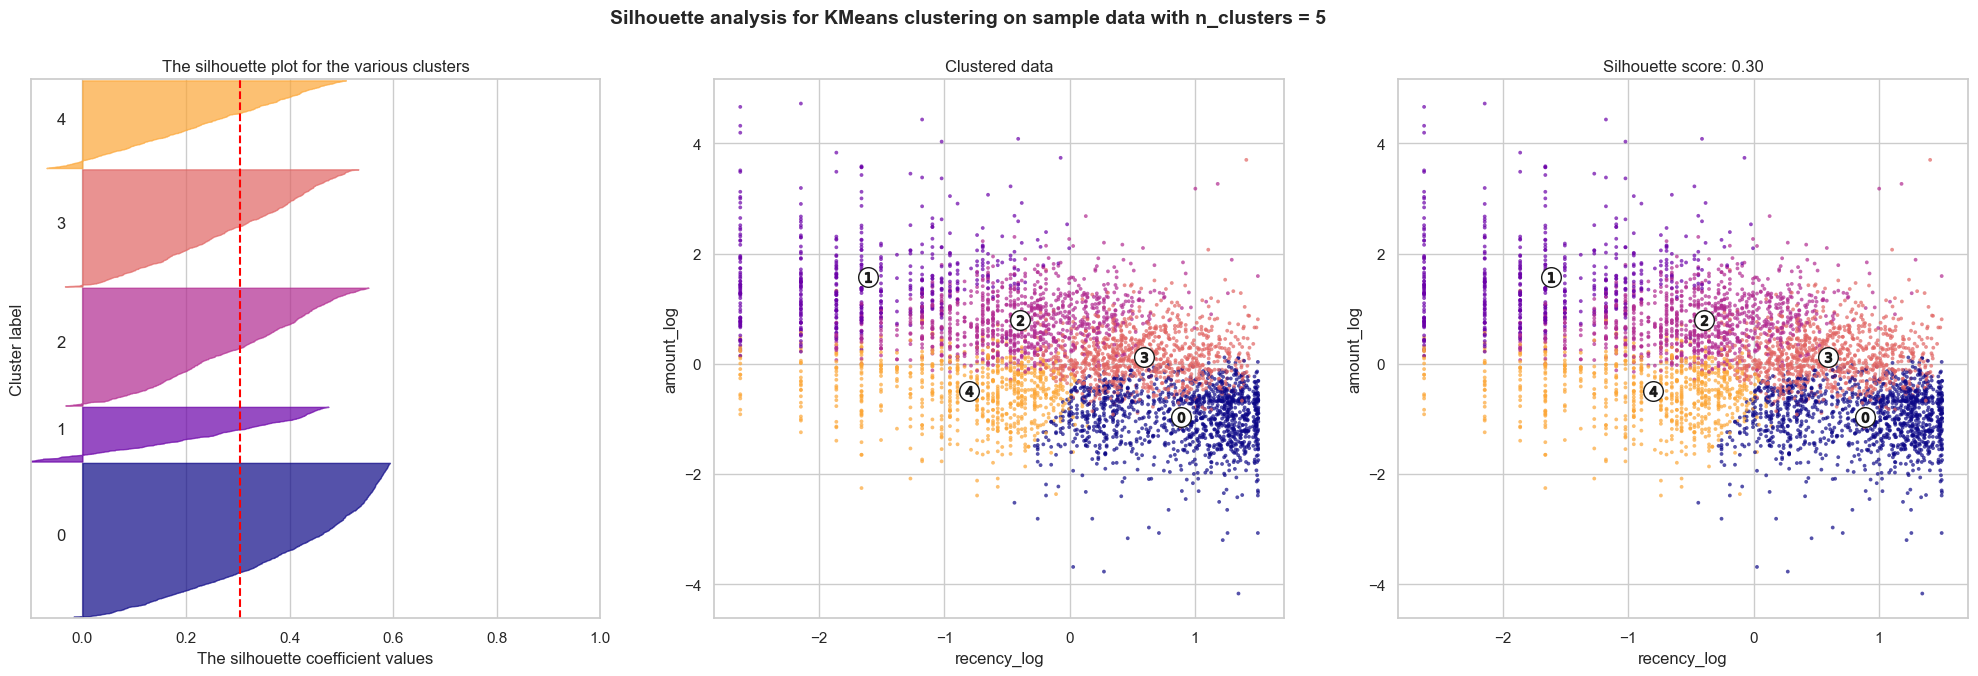

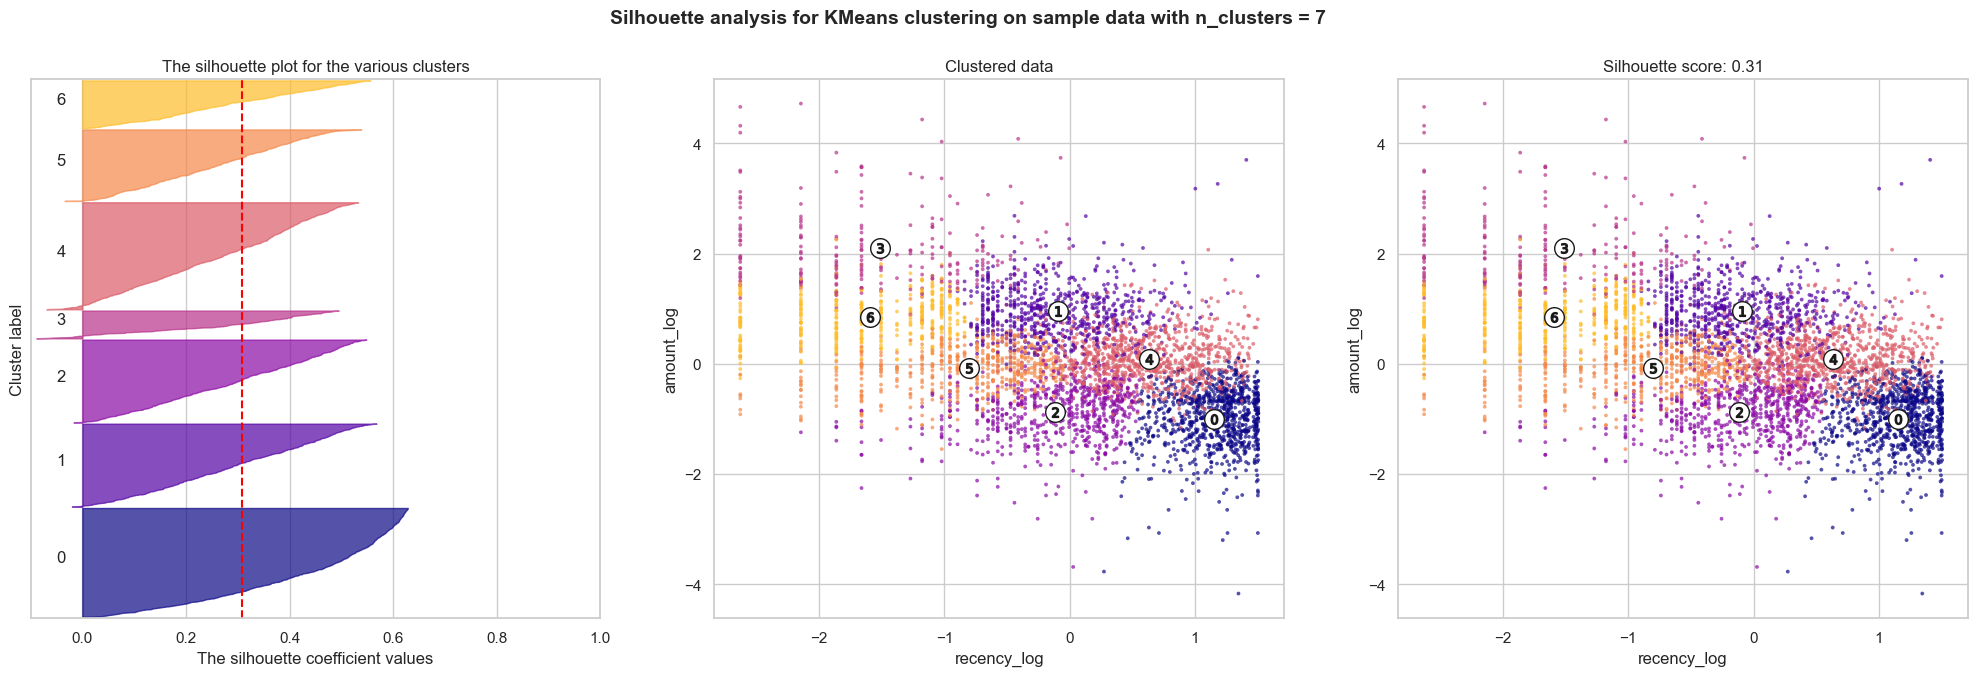

In [97]:
# Initialize dictionary to store results
cluster_centers = {}

# Loop through odd n_clusters from 3 up to K_best
for n_clusters in range(3, K_best + 1, 2):
    # Initialize KMeans model
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,
                       max_iter=300, tol=1e-04, random_state=101)

    # Fit the model and predict cluster labels
    cluster_labels = clusterer.fit_predict(X_scaled)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_scaled, labels=cluster_labels)

    # Store cluster centers, silhouette score, and labels
    cluster_centers[n_clusters] = {
        'cluster_center': clusterer.cluster_centers_,
        'silhouette_score': silhouette_avg,
        'labels': cluster_labels
    }

    # Generate silhouette plot
    sample_silhouette_values = silhouette_samples(X_scaled, labels=cluster_labels)
    y_lower = 10
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

    # Silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.plasma(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])

    # Cluster visualization
    colors = cm.plasma(cluster_labels.astype(float) / n_clusters)
    centers = clusterer.cluster_centers_
    y = 0
    x = 1

    # Plotting clustered data
    for ax, title in zip([ax2, ax3], ["Clustered data", f"Silhouette score: {silhouette_avg:.2f}"]):
        ax.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
        ax.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centers):
            ax.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        ax.set_title(title)
        ax.set_xlabel(feature_vector[x])
        ax.set_ylabel(feature_vector[y])
    
    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')
    plt.show()

#### Clustering Results Insights:

1. **Valid K Clusters**:
   - All `K` cluster options are valid because they do not exhibit clusters with below-average silhouette scores. This suggests that each cluster provides meaningful groupings without poor separation.

2. **Silhouette Plot Fluctuations**:
   - Despite having valid clusters, there are noticeable fluctuations in the size of silhouette plots for each option. This indicates variability in the number of samples within each cluster.

3. **Best Choice Consideration**:
   - The optimal choice may depend on the business relevance. Clusters with sizes closer to desired target groups are preferable as they simplify business interpretation and focus more effectively on specific customer segments.

##### Cluster Centers:

After reversing the log and scaling transformations, we can interpret the cluster center values in their normal form. This allows us to understand the actual group characteristics more effectively in the context of business analysis.

In [98]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  3928.956555    7.218684   9.997198
1   260.222876  116.191967   1.189203
2  1001.720068   34.138812   3.153595
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
        amount     recency  frequency
0   211.549673  153.935498   1.084346
1  5330.428536    4.287685  13.077065
2  1959.126040   24.531810   5.433186
3   841.506177  101.012447   2.356421
4   389.672044   13.720296   1.743406
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    204.950848  225.600151   1.086187
1   2407.089421   37.803327   6.014123
2    237.781336   36.430512   1.132543
3  10156.379437    4.961015  20.687947
4    813.566173  107.106890   2.280821
5    661.120470   13.733298   2.660937
6   2100.809288    4.425310   6.403276

Clusters Insights:

With the plots and the centers in the correct units, let's explore some insights for each cluster group:

#### In the Three-Cluster Configuration:

- The three clusters exhibit distinct differences in the Monetary value of customers, which will be confirmed through a box plot.
- Cluster 1 represents high-value customers who shop frequently and are an important segment for any business.
- Clusters 0 and 2 represent lower and medium spenders, respectively.
- Frequency and Recency are highly correlated with Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

#### In the Five-Cluster Configuration:

- Clusters 0 and 1 are quite similar to their counterparts in the three-cluster configuration.
- Cluster 1 remains robust in affirming customers who shop frequently and spend high amounts.
- Cluster 2 consists of customers who spend reasonably but are not as frequent as Cluster 1.
- Cluster 4 indicates medium-spending customers with relatively low frequency and less recent purchases.
- Cluster 3 represents low-cost purchasers with low frequency but made their last purchase more recently. This group may respond well to price discounts and could be targeted with loyalty promotions to increase the average ticket size. Strategies could be better defined by analyzing market baskets.

#### Five-Cluster Analysis:

- Cluster 6 represents customers who shop frequently and with high monetary value.
- Clusters 1 and 5 show good spending and frequency, differing only in recency of their last purchase. Cluster 5 has older purchase dates, suggesting immediate action to engage this group. Cluster 1, however, needs strategies to increase their frequency.
- Cluster 0 has the fourth-best purchase and a reasonable frequency, but with a long time since their last purchase. This group is likely responsive to promotions and activations to prevent customer loss and stimulate their next purchase.
- Cluster 5 is similar to Cluster 0 but has made more recent purchases with slightly better periodicity. Actions should focus on increasing their frequency and reducing the chances of moving to Cluster 0 due to inactivity.

#### Drill Down Clusters:

To further explore these insights, we can label our data with corresponding cluster labels and visualize these differences. The following code will extract the clustering label and attach it to our customer summary dataset.

In [102]:
# Adding cluster labels to the customer history DataFrame
cust_hist_df['clusters_3'] = cluster_centers[3]['labels']
cust_hist_df['clusters_5'] = cluster_centers[5]['labels']
cust_hist_df['clusters_7'] = cluster_centers[7]['labels']

# Display the first few rows of the DataFrame
display(cust_hist_df.head())

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0       12346      326          1  77183.60     5.786897       0.000000   
1       12347        2          7   4310.00     0.693147       1.945910   
2       12348       75          4   1797.24     4.317488       1.386294   
3       12349       19          1   1757.55     2.944439       0.000000   
4       12350      310          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           2           3           1  
1    8.368693           0           1           6  
2    7.494007           2           2           1  
3    7.471676           2           4           5  
4    5.812338           1           0           0

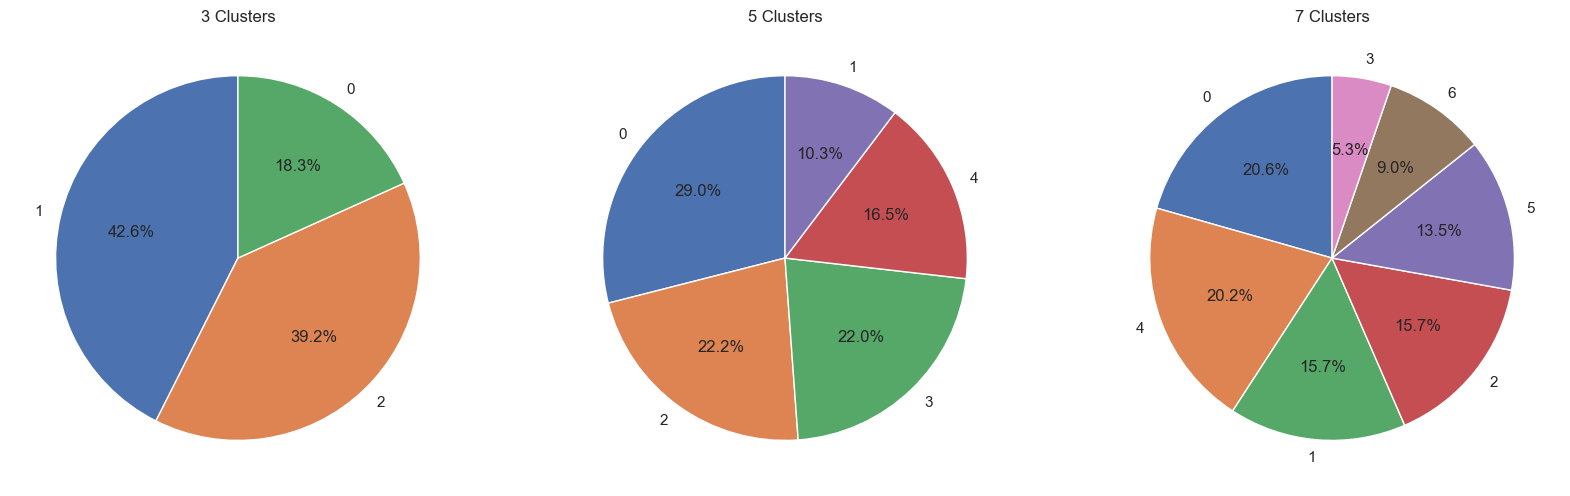

In [104]:
# Visualizing cluster distributions with pie charts
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Plot for 3 Clusters
market_3 = cust_hist_df.clusters_3.value_counts()
axes[0].pie(market_3, labels=market_3.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('3 Clusters')

# Plot for 5 Clusters
market_5 = cust_hist_df.clusters_5.value_counts()
axes[1].pie(market_5, labels=market_5.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('5 Clusters')

# Plot for 7 Clusters
market_7 = cust_hist_df.clusters_7.value_counts()
axes[2].pie(market_7, labels=market_7.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('7 Clusters')

# Display the plots
plt.show()

Once we have assigned labels to each customer, our next step is to analyze how the summary of customers in each group varies. By visualizing this information, we can better understand the differences between clusters and adjust our strategies accordingly.

The following code utilizes Plotly to create interactive boxplots for each cluster configuration. Plotly allows us to explore the central tendency values in each boxplot directly within the notebook. To avoid extreme outliers that may distort the observations, we filter the data such that only data points below the 0.95th percentile of each cluster are considered. This ensures that we focus on the majority of users in each cluster segment, providing more accurate insights into their behaviors.

These visualizations can help confirm or refine the insights we've previously mentioned, allowing you to explore the differences across clusters further.

In [119]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

In [120]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = cust_hist_df[cust_hist_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

Next Steps in Segmentation:

To further enhance discovery and improve the quality of clustering, additional features and customer information can be incorporated into the dataset.

For example:

New indicators such as customer relationship duration, calculated based on the date of the customer's first purchase.
Whether the customer is from abroad or not.
Product groups or categories derived from SKUs.
Leveraging external data sources.
Additionally, exploring different algorithms for segmentation, such as hierarchical clustering, can provide valuable insights. A comprehensive segmentation process will consider these aspects to develop optimal segments that offer meaningful insights.